## import thu vien

In [ ]:
# ==== Standard Library ====
import os
import math
import re
import json
import csv
import itertools
from pathlib import Path
from collections import Counter, defaultdict

# ==== Third-Party Libraries ====
import ijson
import matplotlib.pyplot as plt


## 1 KIỂM TRA XEM CÓ NHIỀU LOẠI ANSWER TRONG BẢNG PROBLEM

In [ ]:

BASE = Path("..")  # từ notebook/ lùi 1 cấp về MOOCcubeX-main
file_path = BASE / "entities" / "problem.json"

def iter_problems(path: Path):
    """Yield từng problem từ file, hỗ trợ cả dạng JSON array và JSON Lines."""
    with path.open("r", encoding="utf-8") as f:
        first = f.read(2048)
        f.seek(0)
        # Heuristic: nếu file bắt đầu bằng '[' => JSON array; ngược lại coi là JSONL
        if first.lstrip().startswith("["):
            data = json.load(f)
            for obj in data:
                yield obj
        else:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                try:
                    yield json.loads(line)
                except json.JSONDecodeError:
                    # Một số dòng có thể có dấu phẩy/trailing; thử xử lý nhẹ
                    line2 = line.rstrip(",")
                    yield json.loads(line2)

def normalize_answer(ans):
    """Trả về list đáp án. Hỗ trợ: list, string JSON list, string đơn."""
    if isinstance(ans, list):
        return ans
    if isinstance(ans, str):
        s = ans.strip()
        # Nếu là chuỗi biểu diễn JSON list, parse
        if s.startswith("[") and s.endswith("]"):
            try:
                v = json.loads(s)
                if isinstance(v, list):
                    return v
            except json.JSONDecodeError:
                pass
        # còn lại coi như một đáp án đơn
        return [s] if s else []
    return []

multi = []
for p in iter_problems(file_path):
    pid = p.get("problem_id") or p.get("id")
    answers = normalize_answer(p.get("answer"))
    if len(answers) > 1:
        multi.append((pid, answers))

print("Số lượng problem có nhiều đáp án:", len(multi))
print("=" * 50)
for pid, answers in multi[:10]:
    print(f"{pid} -> {answers}")


Số lượng problem có nhiều đáp án: 372228
2960 -> ['A', 'B']
2961 -> ['A', 'B', 'C']
2962 -> ['B', 'C']
2963 -> ['B', 'C']
2970 -> ['A', 'C']
3099 -> ['C', 'D']
3101 -> ['A', 'C']
3110 -> ['B', 'D', 'E', 'G']
3112 -> ['C', 'E', 'F', 'G', 'H', 'I']
3121 -> ['A', 'B', 'C', 'D', 'E', 'F']


## 1.1 KIỂM TRA CÁC LOẠI TYPE TRONG BẢNG PROBLEM


In [ ]:

BASE = Path("..")  # từ notebook/ lùi 1 cấp về MOOCcubeX-main
file_path = BASE / "entities" / "problem.json"
 

def iter_problems(path: Path):
    """Yield từng problem từ file, hỗ trợ JSON array và JSON Lines."""
    with path.open("r", encoding="utf-8") as f:
        head = f.read(2048)
        f.seek(0)
        if head.lstrip().startswith("["):  # JSON array
            for obj in json.load(f):
                yield obj
        else:  # JSON Lines (mỗi dòng là một object JSON)
            for line in f:
                line = line.strip().rstrip(",")
                if not line:
                    continue
                yield json.loads(line)

type_counter = Counter()
total = 0

for p in iter_problems(file_path):
    total += 1
    t = p.get("type")   # type là int
    type_counter[t] += 1

print("=== Problem type summary ===")
print(f"Tổng số problem: {total}")
print(f"Số loại type khác nhau: {len(type_counter)}\n")

for t, v in type_counter.most_common():
    print(f"type={t} : {v}")


=== Problem type summary ===
Tổng số problem: 2454422
Số loại type khác nhau: 7

type=1 : 1421943
type=6 : 506384
type=2 : 373580
type=4 : 111956
type=5 : 37409
type=3 : 2869
type=9 : 281


## 1.2 CHO RA 1 DÒNG CHO MỖI LOẠI TYPE TRONG BẢNG PROBLEM


In [ ]:

BASE = Path("..")  # từ notebook/ lùi 1 cấp về MOOCcubeX-main
file_path = BASE / "entities" / "problem.json"


def iter_problems(path: Path):
    """Yield từng problem từ file, hỗ trợ JSON array và JSON Lines."""
    with path.open("r", encoding="utf-8") as f:
        head = f.read(2048)
        f.seek(0)
        if head.lstrip().startswith("["):  # JSON array
            yield from json.load(f)
        else:  # JSON Lines
            for line in f:
                line = line.strip().rstrip(",")
                if line:
                    yield json.loads(line)

# Lấy 1 problem đại diện cho mỗi type
seen_types = set()
unique_by_type = []

for p in iter_problems(file_path):
    t = p.get("type")
    if t not in seen_types:
        seen_types.add(t)
        unique_by_type.append(p)

print("Found", len(unique_by_type), "unique types")

# In toàn bộ JSON của mỗi record đại diện
for p in unique_by_type:
    print(json.dumps(p, ensure_ascii=False, indent=2))
    print("=" * 80)


Found 7 unique types
{
  "problem_id": 1730,
  "title": "第一课 导论与三家分晋--习题",
  "content": "1、《资治通鉴》卷1记载：智宣子将以瑶为后，智果曰：“……瑶之贤于人者五，其不逮者一也。美鬓长大则贤，射御足力则贤，伎艺毕给则贤，巧文辩惠则贤，强毅果敢则贤；如是而甚不仁。夫以其五贤陵人而以不仁行之，其谁能待之？”这是关于智氏家族立接班人的问题，关于智瑶的特点描述，下列哪一项是不符合实际的：",
  "option": {
    "A": "武艺超群，精通射御之术",
    "B": "礼贤下士，虚怀若谷",
    "C": "反映敏捷，文辞和口才俱佳",
    "D": "敢作敢为，处事果断"
  },
  "answer": "[\"B\"]",
  "score": 1.0,
  "type": 1,
  "typetext": "单选题",
  "location": "1.4",
  "context_id": [
    8045581,
    8045582,
    8045583
  ],
  "exercise_id": "Ex_856",
  "language": "Chinese"
}
{
  "problem_id": 2952,
  "title": "第二章 认识照相机（上）--练习题",
  "content": "同样尺寸的传感器，像素点越多，画质越好。",
  "option": {
    "true": "正确",
    "false": "错误"
  },
  "answer": "[\"false\"]",
  "score": 1.0,
  "type": 6,
  "typetext": "判断题",
  "location": "2.9",
  "context_id": [
    1349488,
    1349489,
    6277482,
    6277486,
    6277489,
    6277491,
    6277494,
    6277499
  ],
  "exercise_id": "Ex_1821",
  "language": "Chinese"
}
{
  "problem_id":

## Lựa chọn hợp lý nhất cho thuộc tính `answer`

Để đảm bảo **thống nhất schema** và **không làm mất thông tin** giữa 7 loại `type` trong bảng `problem`, thuộc tính **`answer`** nên được định nghĩa dưới dạng: object<string, array(string)>

#### Nghĩa là:
#### object: kiểu dữ liệu dạng key–value (giống dictionary trong Python, hay object trong JSON).
#### key: luôn là string (ví dụ "ans", "1", "2"...).
#### value: luôn là một mảng (array) gồm các chuỗi (string).

### type 1 - chọn 1 đáp án: { "ans": ["B"] }
### type 2 - chọn nhiều đáp án: { "ans": ["A", "B"] }
### type 3 - survey: { "ans": [] }
### type 4 - fill in the blank - coding: { "1": ["9E"], "2": ["10011110"] }
### type 5 - viết theo ý bạn / tự luận: {}
### type 6 - true/false: { "ans": ["true"] }
### type 9 - không có đáp án: {}


## 1.3 ĐO LƯỜNG GIÁ TRỊ SCORE TRONG BẢNG PROBLEM

In [ ]:

BASE = Path("..")  # từ notebook/ lùi 1 cấp về MOOCcubeX-main
file_path = BASE / "entities" / "problem.json"
PROBLEM_PATH = file_path

def iter_problems(path):
    """Đọc tuần tự từng problem object từ file JSON lớn."""
    with open(path, "rb") as f:
        # Nếu file là mảng JSON [ {...}, {...}, ... ]
        first = f.read(1)
        f.seek(0)
        if first == b'[':
            for obj in ijson.items(f, "item"):
                yield obj
        else:  # JSON nối tiếp hoặc JSON Lines
            for obj in ijson.items(f, "", multiple_values=True):
                yield obj

score_min = math.inf
score_max = -math.inf
count = 0

for pb in iter_problems(PROBLEM_PATH):
    s = pb.get("score")
    if s is None:
        continue
    try:
        val = float(s)
    except Exception:
        continue

    if val < score_min:
        score_min = val
    if val > score_max:
        score_max = val
    count += 1

print("===== PROBLEM.SCORE MIN–MAX =====")
print(f"Số lượng problem có score: {count}")
print(f"Score min: {score_min}")
print(f"Score max: {score_max}")


===== PROBLEM.SCORE MIN–MAX =====
Số lượng problem có score: 1880050
Score min: 0.0
Score max: 100.0


### 1.3.1 in ra 5 dòng có score = 100 và score = 0

In [6]:
# Lấy ví dụ 5 dòng có score = 100 và 5 dòng có score = 0
examples_100 = []
examples_0 = []

for pb in iter_problems(PROBLEM_PATH):  # sử dụng hàm iter_problems đã định nghĩa ở trên
    s = pb.get("score")
    if s is None:
        continue
    try:
        val = float(s)
    except Exception:
        continue

    if val == 100.0 and len(examples_100) < 5:
        examples_100.append({
            "problem_id": pb.get("problem_id"),
            "exercise_id": pb.get("exercise_id"),
            "score": val,
            "type": pb.get("type"),
            "typetext": pb.get("typetext"),
            "title": pb.get("title")
        })

    if val == 0.0 and len(examples_0) < 5:
        examples_0.append({
            "problem_id": pb.get("problem_id"),
            "exercise_id": pb.get("exercise_id"),
            "score": val,
            "type": pb.get("type"),
            "typetext": pb.get("typetext"),
            "title": pb.get("title")
        })

    if len(examples_100) >= 5 and len(examples_0) >= 5:
        break

print("===== 5 Examples with score = 100 =====")
for ex in examples_100:
    print(ex)

print("\n===== 5 Examples with score = 0 =====")
for ex in examples_0:
    print(ex)


===== 5 Examples with score = 100 =====
{'problem_id': 437968, 'exercise_id': 'Ex_334851', 'score': 100.0, 'type': 1, 'typetext': '单选题', 'title': '第一节  肾小球的滤过功能--作业'}
{'problem_id': 437969, 'exercise_id': 'Ex_334853', 'score': 100.0, 'type': 1, 'typetext': '单选题', 'title': '第二节  肾小管和集合管的物质转运功能--作业'}
{'problem_id': 1085471, 'exercise_id': 'Ex_882743', 'score': 100.0, 'type': 5, 'typetext': '主观题', 'title': '编写需求文档'}
{'problem_id': 1085485, 'exercise_id': 'Ex_882761', 'score': 100.0, 'type': 5, 'typetext': '主观题', 'title': '总体设计文档'}
{'problem_id': 1085506, 'exercise_id': 'Ex_882777', 'score': 100.0, 'type': 5, 'typetext': '主观题', 'title': '补充设计文档'}

===== 5 Examples with score = 0 =====
{'problem_id': 471588, 'exercise_id': 'Ex_359137', 'score': 0.0, 'type': 5, 'typetext': '主观题', 'title': '8.7 案例研究-机动目标跟踪'}
{'problem_id': 847981, 'exercise_id': 'Ex_673543', 'score': 0.0, 'type': 5, 'typetext': '主观题', 'title': '8.7 案例研究-机动目标跟踪'}
{'problem_id': 933823, 'exercise_id': 'Ex_715243', 'score': 0.0,

### 1.3.2 Lọc ra các type có trong score = 100 và score = 0

In [7]:
types_100 = set()
types_0 = set()

for pb in iter_problems(PROBLEM_PATH): # sử dụng hàm iter_problems đã định nghĩa ở trên
    s = pb.get("score")
    if s is None:
        continue
    try:
        val = float(s)
    except Exception:
        continue

    if val == 100.0:
        if "type" in pb:
            types_100.add(pb["type"])
    elif val == 0:
        if "type" in pb:
            types_0.add(pb["type"])

print("===== Unique TYPEs with score = 100 =====")
print(types_100)

print("\n===== Unique TYPEs with score = 0 =====")
print(types_0)


===== Unique TYPEs with score = 100 =====
{1, 3, 5, 9}

===== Unique TYPEs with score = 0 =====
{1, 2, 3, 4, 5, 6}


## 1.4 Đo lường miền giá trị language trong bảng PROBLEM

In [6]:
# Đếm và liệt kê toàn bộ giá trị language
languages = set()

for p in iter_problems(PROBLEM_PATH):
    lang = p.get("language")
    if lang is not None:
        languages.add(lang)

print("Số lượng giá trị khác nhau của language:", len(languages))
print("Danh sách language:", list(languages))


Số lượng giá trị khác nhau của language: 2
Danh sách language: ['Chinese', 'English']


## 2.1 Đếm ID mỗi file


In [ ]:
# ======================
# Locate data folders
# ======================
BASE = Path("..")        # từ notebook/ lùi về gốc MOOCcubeX-main
ENT = BASE / "entities"
REL = BASE / "relations"

# ======================
# Helpers
# ======================
def load_json_any(path: Path):
    """Load JSON array hoặc JSON Lines (NDJSON)."""
    with path.open(encoding="utf-8") as f:
        head = f.read(2048)
        f.seek(0)
        if head.lstrip().startswith("["):
            return json.load(f)
        else:
            return [json.loads(line.strip().rstrip(",")) for line in f if line.strip()]

def load_tsv_ids(path: Path, col: int):
    """Đọc file .txt 2 cột (tab) và trả về set ID của 1 cột."""
    out = set()
    with path.open(encoding="utf-8") as f:
        for line in f:
            parts = line.rstrip("\n").split("\t")
            if len(parts) > col:
                out.add(parts[col])
    return out


print("==== Unique ID counts (by schema) ====")

# ----------------------
# entities/course.json
# ----------------------
courses = load_json_any(ENT / "course.json")
course_ids = {c.get("id") for c in courses if c.get("id")}
print(f"Course IDs (entities/course.json → id): {len(course_ids)}")

# Đếm resource theo loại (video/exercise) dựa trên resource_id prefix
res_video_ids = set()
res_exercise_ids = set()
for c in courses:
    for r in (c.get("resource") or []):
        rid = r.get("resource_id")
        if isinstance(rid, str):
            if rid.startswith("V_"):
                res_video_ids.add(rid)
            elif rid.startswith("Ex_"):
                res_exercise_ids.add(rid)
print(f"  └─ Resource video_ids in course.json (V_*): {len(res_video_ids)}")
print(f"  └─ Resource exercise_ids in course.json (Ex_*): {len(res_exercise_ids)}")

# ----------------------
# entities/video.json
# ----------------------
videos = load_json_any(ENT / "video.json")
ccids = {v.get("ccid") for v in videos if v.get("ccid")}
print(f"Video CCIDs (entities/video.json → ccid): {len(ccids)}")

# ----------------------
# entities/problem.json
# ----------------------
problems = load_json_any(ENT / "problem.json")
problem_ids = {p.get("problem_id") for p in problems if p.get("problem_id")}  # theo mô tả: id bắt đầu Pm_
print(f"Problem IDs (entities/problem.json → id): {len(problem_ids)}")

# ----------------------
# entities/school.json
# ----------------------
schools = load_json_any(ENT / "school.json")
school_ids = {s.get("id") for s in schools if s.get("id")}
print(f"School IDs (entities/school.json → id): {len(school_ids)}")

# ----------------------
# entities/teacher.json
# ----------------------
teachers = load_json_any(ENT / "teacher.json")
teacher_ids = {t.get("id") for t in teachers if t.get("id")}
print(f"Teacher IDs (entities/teacher.json → id): {len(teacher_ids)}")

# ----------------------
# relations/course-field.json
# ----------------------
course_field = load_json_any(REL / "course-field.json")
cf_course_ids = {row.get("course_id") for row in course_field if row.get("course_id")}
# Tập field (danh sách thủ công) có thể là list -> gộp tất cả phần tử
cf_fields = set()
for row in course_field:
    fields = row.get("field") or []
    if isinstance(fields, list):
        for f in fields:
            if f:
                cf_fields.add(str(f))
print(f"Course-field (relations/course-field.json → course_id): {len(cf_course_ids)} courses")
print(f"  └─ Distinct labeled fields: {len(cf_fields)}")

# ----------------------
# relations/course-school.txt
# ----------------------
cs_courses  = load_tsv_ids(REL / "course-school.txt", 0)
cs_schools  = load_tsv_ids(REL / "course-school.txt", 1)
print(f"Course-School (relations/course-school.txt): {len(cs_courses)} courses, {len(cs_schools)} schools")

# ----------------------
# relations/course-teacher.txt
# ----------------------
ct_courses  = load_tsv_ids(REL / "course-teacher.txt", 0)
ct_teachers = load_tsv_ids(REL / "course-teacher.txt", 1)
print(f"Course-Teacher (relations/course-teacher.txt): {len(ct_courses)} courses, {len(ct_teachers)} teachers")

# ----------------------
# relations/exercise-problem.txt
# ----------------------
ex_ids  = load_tsv_ids(REL / "exercise-problem.txt", 0)
pb_ids_rel = load_tsv_ids(REL / "exercise-problem.txt", 1)
print(f"Exercise-Problem (relations/exercise-problem.txt): {len(ex_ids)} exercises, {len(pb_ids_rel)} problems")

# ----------------------
# relations/video_id-ccid.txt
# ----------------------
video_ids_rel = load_tsv_ids(REL / "video_id-ccid.txt", 0)
ccids_rel     = load_tsv_ids(REL / "video_id-ccid.txt", 1)
print(f"Video-CCID (relations/video_id-ccid.txt): {len(video_ids_rel)} video_ids, {len(ccids_rel)} ccids")


==== Unique ID counts (by schema) ====
Course IDs (entities/course.json → id): 3781
  └─ Resource video_ids in course.json (V_*): 203718
  └─ Resource exercise_ids in course.json (Ex_*): 67325
Video CCIDs (entities/video.json → ccid): 59581
Problem IDs (entities/problem.json → id): 2454422
School IDs (entities/school.json → id): 429
Teacher IDs (entities/teacher.json → id): 17018
Course-field (relations/course-field.json → course_id): 632 courses
  └─ Distinct labeled fields: 82
Course-School (relations/course-school.txt): 3951 courses, 494 schools
Course-Teacher (relations/course-teacher.txt): 13866 courses, 12252 teachers
Exercise-Problem (relations/exercise-problem.txt): 888742 exercises, 6251341 problems
Video-CCID (relations/video_id-ccid.txt): 2798892 video_ids, 230263 ccids


### 🔹 Unique ID counts (by schema)

1. **Course IDs (`entities/course.json → id`)**: **3781**  
   - Resource `video_ids`: **203,718**  
   - Resource `exercise_ids`: **67,325**

2. **Video CCIDs (`entities/video.json → ccid`)**: **59,581**  
   - Một `ccid` = 1 video duy nhất.  
   - Nhiều `video_id` có thể ánh xạ tới cùng một `ccid`.

3. **Problem IDs (`entities/problem.json → id`)**: **2,454,422**  
   - Tổng số câu hỏi thuộc về các bài tập.

4. **School IDs (`entities/school.json → id`)**: **429**  
   - Số lượng trường trong dữ liệu.

5. **Teacher IDs (`entities/teacher.json → id`)**: **17,018**  
   - Số lượng giáo viên.

6. **Course-field (`relations/course-field.json → course_id`)**: **632 courses**  
   - Có **82 distinct labeled fields** (lĩnh vực khác nhau).

7. **Course-School (`relations/course-school.txt`)**:  
   - **3951 courses** gắn với **494 schools**.

8. **Course-Teacher (`relations/course-teacher.txt`)**:  
   - **13,866 courses** gắn với **12,252 teachers**.

9. **Exercise-Problem (`relations/exercise-problem.txt`)**:  
   - **888,742 exercises**  
   - **6,251,341 problems** (tổng số câu hỏi liên kết).

10. **Video-CCID (`relations/video_id-ccid.txt`)**:  
    - **2,798,892 video_ids**  
    - ánh xạ thành **230,263 ccids**.
**Tóm gọn**:  
- Courses: 3781  
- Videos: 2.8M video_ids → 230k ccids → 59k có phụ đề chi tiết  
- Exercises: 888k exercises → 6.25M problems  
- Schools: 429  
- Teachers: 17k  
- Fields: 82  


## 2.2 Kiểm tra relation của file course-school.txt

In [ ]:
BASE = Path("..")
COURSE_JSON = BASE / "entities" / "course.json"
SCHOOL_JSON = BASE / "entities" / "school.json"
REL_FILE    = BASE / "relations" / "course-school.txt"

def iter_json_objects(path: Path):
    """Đọc file JSON dạng array hoặc JSON Lines. Yield từng object."""
    with path.open("r", encoding="utf-8") as f:
        head = f.read(2048)
        f.seek(0)
        if head.lstrip().startswith("["):      # JSON array
            data = json.load(f)
            for obj in data:
                yield obj
        else:                                   # JSON Lines
            for line in f:
                line = line.strip().rstrip(",")
                if line:
                    yield json.loads(line)

# 1) Tập ID gốc (giữ nguyên dạng string)
course_ids = {
    str(obj["id"]).strip() for obj in iter_json_objects(COURSE_JSON) if "id" in obj
}
school_ids = {
    str(obj["id"]).strip() for obj in iter_json_objects(SCHOOL_JSON) if "id" in obj
}

# 2) Đọc quan hệ course-school (TSV: course_id \t school_id)
pairs = []
with REL_FILE.open("r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        parts = line.split("\t")
        if len(parts) != 2:
            continue
        c_id, s_id = parts[0].strip(), parts[1].strip()
        pairs.append((c_id, s_id))

# 3) Thống kê & mismatch
total_rows = len(pairs)
unique_pairs = set(pairs)
courses_in_rel = {c for c, _ in unique_pairs}
schools_in_rel = {s for _, s in unique_pairs}

missing_courses = sorted(courses_in_rel - course_ids)        # có trong relation nhưng không có trong course.json
missing_schools = sorted(schools_in_rel - school_ids)        # có trong relation nhưng không có trong school.json

courses_without_school = sorted(course_ids - courses_in_rel) # có trong course.json nhưng không xuất hiện trong relation
schools_without_course = sorted(school_ids - schools_in_rel) # có trong school.json nhưng không xuất hiện trong relation

print("===== COURSE–SCHOOL CONSISTENCY REPORT =====")
print(f"Rows in relations file:         {total_rows:,}")
print(f"Unique (course, school) pairs:  {len(unique_pairs):,}")
print()
print(f"Courses in course.json:         {len(course_ids):,}")
print(f"Courses referenced in relation: {len(courses_in_rel):,}")
print(f"→ Missing courses (relation ↛ course.json): {len(missing_courses):,}")
print(f"→ Courses without any school (only in course.json): {len(courses_without_school):,}")
print()
print(f"Schools in school.json:         {len(school_ids):,}")
print(f"Schools referenced in relation: {len(schools_in_rel):,}")
print(f"→ Missing schools (relation ↛ school.json): {len(missing_schools):,}")
print(f"→ Schools without any course (only in school.json): {len(schools_without_course):,}")

# In toàn bộ danh sách mismatch
def show_all(name, seq):
    print(f"\n{name} (total: {len(seq)})")
    for item in seq:
        print(item)

# In ra toàn bộ các nhóm mismatch
show_all("Missing course_ids (relation ↛ course.json)", missing_courses)
show_all("Missing school_ids (relation ↛ school.json)", missing_schools)
show_all("Course_ids without school (only in course.json)", courses_without_school)
show_all("School_ids without course (only in school.json)", schools_without_course)


===== COURSE–SCHOOL CONSISTENCY REPORT =====
Rows in relations file:         3,983
Unique (course, school) pairs:  3,983

Courses in course.json:         3,781
Courses referenced in relation: 3,951
→ Missing courses (relation ↛ course.json): 234
→ Courses without any school (only in course.json): 64

Schools in school.json:         429
Schools referenced in relation: 494
→ Missing schools (relation ↛ school.json): 70
→ Schools without any course (only in school.json): 5

Missing course_ids (relation ↛ course.json) (total: 234)
C_1683272
C_1687718
C_1691445
C_1760124
C_1770762
C_1774217
C_1777789
C_1786036
C_1797545
C_1804563
C_1821297
C_1837160
C_1852868
C_1885861
C_1891513
C_1896435
C_1899111
C_1903967
C_1903969
C_1903970
C_1904004
C_1907221
C_1912171
C_1912176
C_1912213
C_1912362
C_1912765
C_1918246
C_1940511
C_1940683
C_2019288
C_2141849
C_2203591
C_2206036
C_2211873
C_2221588
C_2221592
C_2235708
C_2248772
C_2255360
C_2258690
C_2287290
C_2290891
C_2294668
C_2297700
C_2305260
C_23053

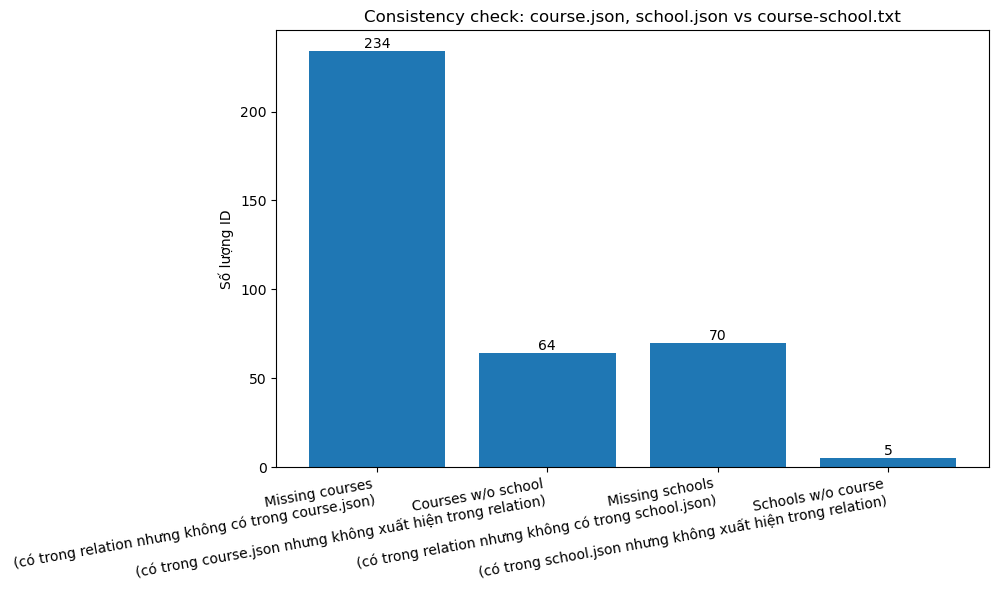

In [ ]:
# 1) Gom số liệu
stats = {
    "Missing courses\n(có trong relation nhưng không có trong course.json)": len(missing_courses),
    "Courses w/o school\n(có trong course.json nhưng không xuất hiện trong relation)": len(courses_without_school),
    "Missing schools\n(có trong relation nhưng không có trong school.json)": len(missing_schools),
    "Schools w/o course\n(có trong school.json nhưng không xuất hiện trong relation)": len(schools_without_course),
}

# 2) Vẽ cột
labels = list(stats.keys())
values = list(stats.values())

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values)

# 3) Ghi số lên đỉnh cột
for b in bars:
    height = b.get_height()
    plt.text(b.get_x() + b.get_width()/2, height, f"{int(height):,}",
             ha="center", va="bottom", fontsize=10)

plt.title("Consistency check: course.json, school.json vs course-school.txt")
plt.ylabel("Số lượng ID")
plt.xticks(rotation=10, ha="right")
plt.tight_layout()
plt.show()


## Đánh giá mối quan hệ course-school

### 1. Tổng quan
- **Rows in relations file:** 3,983  
- **Unique (course, school) pairs:** 3,983  

→ Toàn bộ các dòng trong `course-school.txt` là cặp duy nhất, không có trùng lặp.

---

### 2. Khóa học (Courses)
- **Courses in `course.json`:** 3,781  
- **Courses referenced in relation:** 3,951  
- **Missing courses (relation ↛ course.json):** 234  
- **Courses without any school (only in course.json):** 64  

Có 234 `course_id` xuất hiện trong quan hệ nhưng không tồn tại trong `course.json`.  
Ngoài ra có 64 khóa học trong `course.json` không liên kết với bất kỳ trường nào.

---

### 3. Trường học (Schools)
- **Schools in `school.json`:** 429  
- **Schools referenced in relation:** 494  
- **Missing schools (relation ↛ school.json):** 70  
- **Schools without any course (only in school.json):** 5  

Có 70 `school_id` chỉ xuất hiện trong quan hệ nhưng không có trong `school.json`.  
Ngoài ra có 5 trường tồn tại trong `school.json` nhưng không liên kết với bất kỳ khóa học nào.

---

### 4. Kết luận
- Dữ liệu quan hệ `course-school.txt` không hoàn toàn đồng nhất với các bảng gốc.  
- Có sự **thừa ID** (234 course, 70 school).  
- Có sự **thiếu liên kết** (64 course không có trường, 5 trường không có course).  

Khi phân tích cần chú ý:
1. Chuẩn hoá lại ID.  
2. Xác minh dữ liệu hoặc cập nhật lại mapping.  
3. Quyết định có loại bỏ các node “mồ côi” hay giữ lại khi làm phân tích mạng.  


### 📌 Giải thích công thức tính số lượng Course trong `relation`

Giả sử:  
- `C_json` = tập `course_id` trong **course.json**  
- `C_rel` = tập `course_id` xuất hiện trong **course-school.txt**  

Khi so sánh, sẽ có 2 loại sai khác:  
- `only_in_relation = C_rel \ C_json` → các khóa học có trong quan hệ nhưng **không tồn tại** trong `course.json`.  
- `only_in_course = C_json \ C_rel` → các khóa học có trong `course.json` nhưng **không xuất hiện** trong quan hệ.  

Do đó, công thức:

\[
|C_{rel}| = |C_{json}| - |only\_in\_course| + |only\_in\_relation|
\]

---

### 🔹 Áp dụng số liệu
- `|C_json| = 3781`  
- `|only_in_course| = 64`  
- `|only_in_relation| = 234`  

\[
|C_{rel}| = 3781 - 64 + 234 = 3951
\]

---

### ✅ Kết luận
Số **Courses referenced in relation = 3,951** là đúng,  
không phải tính bằng `3781 + 234` trực tiếp.


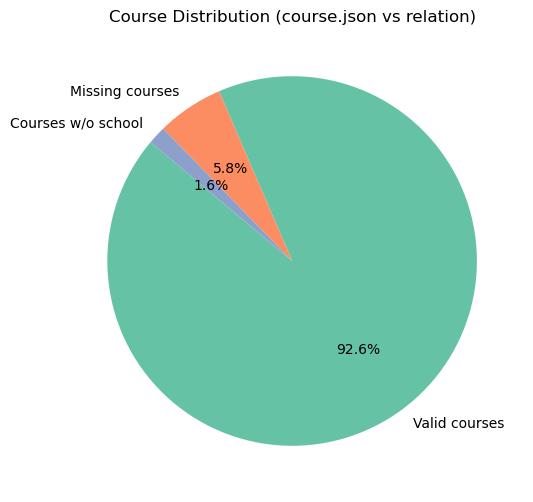

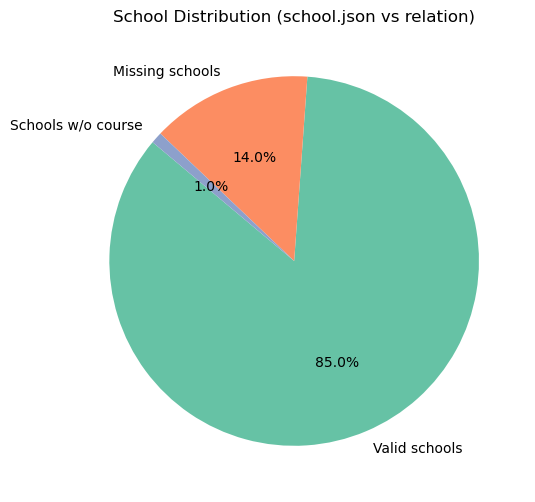

In [ ]:
# Lấy mẫu 2 biểu đồ tròn theo relation course-school.txt

# ==== Pie chart cho COURSE ====
valid_courses = len(courses_in_rel & course_ids)
missing_courses_count = len(missing_courses)
orphan_courses = len(courses_without_school)

course_labels = ["Valid courses", "Missing courses", "Courses w/o school"]
course_sizes = [valid_courses, missing_courses_count, orphan_courses]
course_colors = ["#66c2a5", "#fc8d62", "#8da0cb"]

plt.figure(figsize=(6,6))
plt.pie(course_sizes, labels=course_labels, autopct="%1.1f%%", colors=course_colors, startangle=140)
plt.title("Course Distribution (course.json vs relation)")
plt.show()


# ==== Pie chart cho SCHOOL ====
valid_schools = len(schools_in_rel & school_ids)
missing_schools_count = len(missing_schools)
orphan_schools = len(schools_without_course)

school_labels = ["Valid schools", "Missing schools", "Schools w/o course"]
school_sizes = [valid_schools, missing_schools_count, orphan_schools]
school_colors = ["#66c2a5", "#fc8d62", "#8da0cb"]

plt.figure(figsize=(6,6))
plt.pie(school_sizes, labels=school_labels, autopct="%1.1f%%", colors=school_colors, startangle=140)
plt.title("School Distribution (school.json vs relation)")
plt.show()


## Phân loại dữ liệu Course và School

### 🔹 Với Course
- **Courses hợp lệ**: có trong cả `course.json` và `relation`.  
- **Courses bị thiếu**: có trong `relation` nhưng không có trong `course.json`.  
- **Courses “mồ côi”**: có trong `course.json` nhưng không gắn với trường nào.  

### 🔹 Với School
- **Schools hợp lệ**: có trong cả `school.json` và `relation`.  
- **Schools bị thiếu**: có trong `relation` nhưng không có trong `school.json`.  
- **Schools “mồ côi”**: có trong `school.json` nhưng không gắn với course nào.  


### KIỂM TRA LOẠI MỐI QUAN HỆ GIỮA SCHOOL VÀ COURSE: N-N

In [ ]:


# ==== Đường dẫn giống cấu trúc bạn đang dùng ====
BASE = Path("..")  # đổi thành Path(".") nếu notebook ở thư mục gốc dự án
COURSE_JSON = BASE / "entities" / "course.json"
SCHOOL_JSON = BASE / "entities" / "school.json"
REL_FILE    = BASE / "relations" / "course-school.txt"

def iter_json_objects(path: Path):
    """Đọc file JSON dạng array hoặc JSON Lines. Yield từng object."""
    with path.open("r", encoding="utf-8") as f:
        head = f.read(2048)
        f.seek(0)
        if head.lstrip().startswith("["):      # JSON array
            data = json.load(f)
            for obj in data:
                yield obj
        else:                                   # JSON Lines
            for line in f:
                line = line.strip().rstrip(",")
                if line:
                    yield json.loads(line)

# 1) Tập ID gốc (giữ nguyên dạng string)
course_ids = {str(o["id"]).strip() for o in iter_json_objects(COURSE_JSON) if "id" in o}
school_ids = {str(o["id"]).strip() for o in iter_json_objects(SCHOOL_JSON) if "id" in o}

# 2) Đọc quan hệ course-school (TSV: course_id \t school_id)
pairs = []
with REL_FILE.open("r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        parts = line.split("\t")
        if len(parts) != 2:
            continue
        c_id, s_id = parts[0].strip(), parts[1].strip()
        pairs.append((c_id, s_id))

# Loại trùng
unique_pairs = set(pairs)

# 3) Chỉ xét các cặp HỢP LỆ (ID có trong bảng gốc)
valid_unique_pairs = {(c, s) for (c, s) in unique_pairs if (c in course_ids) and (s in school_ids)}

# 4) Map 2 chiều
school_to_courses = defaultdict(set)
course_to_schools = defaultdict(set)
for c_id, s_id in valid_unique_pairs:
    school_to_courses[s_id].add(c_id)
    course_to_schools[c_id].add(s_id)

# 5) Trường có nhiều khóa (>=2) + danh sách course
schools_many_courses = []
for s_id, courses in school_to_courses.items():
    if len(courses) >= 2:
        schools_many_courses.append({
            "school_id": s_id,
            "num_courses": len(courses),
            "course_ids": sorted(courses),
        })
schools_many_courses.sort(key=lambda r: r["num_courses"], reverse=True)

print(f"Schools with >= 2 courses: {len(schools_many_courses)}")
for row in schools_many_courses[:5]:
    print(f"- {row['school_id']}: {row['num_courses']} courses")
    print("  sample:", row["course_ids"][:10], ("... +" if len(row["course_ids"])>10 else ""))

# 6) Các course chỉ gắn đúng 1 trường
single_school_courses = []
for c_id, schools in course_to_schools.items():
    if len(schools) == 1:
        s = next(iter(schools))
        single_school_courses.append({"course_id": c_id, "school_id": s})

print(f"\nCourses with exactly 1 school: {len(single_school_courses)}")
print("Preview (first 10):", single_school_courses[:10])



Schools with >= 2 courses: 319
- S_1: 516 courses
  sample: ['C_1159827', 'C_1168945', 'C_1169394', 'C_1410156', 'C_1428968', 'C_1429002', 'C_1527465', 'C_1647264', 'C_1724291', 'C_1736850'] ... +
- S_63: 224 courses
  sample: ['C_1328548', 'C_1627979', 'C_1628052', 'C_1628160', 'C_1682756', 'C_1682805', 'C_1682833', 'C_1691144', 'C_1691453', 'C_1703785'] ... +
- S_31: 120 courses
  sample: ['C_1527407', 'C_1683594', 'C_1696148', 'C_1724285', 'C_1750795', 'C_1765600', 'C_1766165', 'C_1766166', 'C_1766167', 'C_1766168'] ... +
- S_11: 57 courses
  sample: ['C_1646044', 'C_1755917', 'C_1755919', 'C_1755920', 'C_1756072', 'C_1756073', 'C_1764844', 'C_1771168', 'C_1774971', 'C_1774978'] ... +
- S_7: 57 courses
  sample: ['C_1771164', 'C_1825362', 'C_1875536', 'C_1925906', 'C_2306764', 'C_2308093', 'C_2308096', 'C_2335756', 'C_676695', 'C_676890'] ... +

Courses with exactly 1 school: 3555
Preview (first 10): [{'course_id': 'C_948142', 'school_id': 'S_68'}, {'course_id': 'C_697506', 'school_

In [ ]:
# 1) Map theo ALL pairs (không lọc hợp lệ) và VALID pairs
course_to_schools_all = defaultdict(set)
course_to_schools_valid = defaultdict(set)

for c_id, s_id in unique_pairs:               # all pairs
    course_to_schools_all[c_id].add(s_id)

valid_pairs = {(c,s) for (c,s) in unique_pairs if (c in course_ids) and (s in school_ids)}
for c_id, s_id in valid_pairs:                # only valid pairs
    course_to_schools_valid[c_id].add(s_id)

# 2) Phân loại course trong course.json
total_courses = len(course_ids)

# 2.1 Không có quan hệ nào trong relation
eq0_no_relation = [c for c in course_ids if c not in course_to_schools_all]
# (đây chính là courses_without_school đã tính trước)

# 2.2 Có quan hệ nhưng toàn school_id không hợp lệ (nên valid=0)
eq0_invalid_only = [
    c for c in course_ids
    if (len(course_to_schools_all.get(c, set())) > 0) and (len(course_to_schools_valid.get(c, set())) == 0)
]

# 2.3 Exactly 1 school hợp lệ
eq1_valid = [c for c in course_ids if len(course_to_schools_valid.get(c, set())) == 1]

# 2.4 >1 school hợp lệ
gt1_valid = [c for c in course_ids if len(course_to_schools_valid.get(c, set())) > 1]

print("===== COURSE BREAKDOWN (must sum to total_courses) =====")
print(f"Total courses in course.json:                {total_courses}")
print(f"  A) No relation at all:                     {len(eq0_no_relation)}")
print(f"  B) Only invalid schools (valid=0):         {len(eq0_invalid_only)}")
print(f"  C) Exactly 1 valid school:                 {len(eq1_valid)}   <-- (con số 3,555 của bạn)")
print(f"  D) >1 valid schools:                       {len(gt1_valid)}")

check_sum = len(eq0_no_relation) + len(eq0_invalid_only) + len(eq1_valid) + len(gt1_valid)
print(f"\nCheck sum = {check_sum} (should equal {total_courses})")

# (tuỳ chọn) xem nhanh vài ví dụ
print("\nExamples of B) only invalid schools (up to 10):")
for c in eq0_invalid_only[:10]:
    print(c, "→ all schools:", sorted(course_to_schools_all[c]), "| valid:", sorted(course_to_schools_valid.get(c, set())))
print("\nExamples of D) >1 valid schools (up to 10):")
for c in gt1_valid[:10]:
    print(c, "→ valid schools:", sorted(course_to_schools_valid[c]))


===== COURSE BREAKDOWN (must sum to total_courses) =====
Total courses in course.json:                3781
  A) No relation at all:                     64
  B) Only invalid schools (valid=0):         137
  C) Exactly 1 valid school:                 3555   <-- (con số 3,555 của bạn)
  D) >1 valid schools:                       25

Check sum = 3781 (should equal 3781)

Examples of B) only invalid schools (up to 10):
C_682286 → all schools: ['S_265'] | valid: []
C_697602 → all schools: ['S_60'] | valid: []
C_1910455 → all schools: ['S_912'] | valid: []
C_680920 → all schools: ['S_147'] | valid: []
C_681272 → all schools: ['S_192'] | valid: []
C_1755953 → all schools: ['S_60'] | valid: []
C_682603 → all schools: ['S_243'] | valid: []
C_681610 → all schools: ['S_223'] | valid: []
C_948107 → all schools: ['S_746'] | valid: []
C_2252926 → all schools: ['S_1206'] | valid: []

Examples of D) >1 valid schools (up to 10):
C_734054 → valid schools: ['S_1', 'S_84']
C_707384 → valid schools: ['S_1',

### Course–School Breakdown (3,781 courses)

Kết quả phân tích toàn bộ `course.json` so với `course-school.txt`:

1. **A) No relation at all → 64 courses**  
   - Các khóa học không xuất hiện trong `course-school.txt`.  
   - → Không gắn với bất kỳ trường nào.

2. **B) Only invalid schools → 137 courses**  
   - Các khóa học chỉ gắn với `school_id` **không tồn tại trong `school.json`**.  
   - Ví dụ: `C_682664` gắn với `S_243` (không hợp lệ).  

3. **C) Exactly 1 valid school → 3,555 courses**  
   - Mỗi khóa học gắn với **chính xác 1 trường hợp lệ**.  
   - Đây là nhóm lớn nhất (≈ 94% tổng số courses).  

4. **D) >1 valid schools → 25 courses**  
   - Có khóa học gắn với **từ 2 trường hợp lệ trở lên**.  
   - Ví dụ: `C_681509` gắn với cả `S_208` và `S_63`.  
   - Điều này chứng minh một số khóa học có thể thuộc nhiều trường.

### Kết luận
- Tổng số 3,781 khóa học = **64 (A) + 137 (B) + 3,555 (C) + 25 (D)**.  
- Quan hệ **không hoàn toàn là 1–N**, vì có 25 khóa học liên kết với nhiều trường.  
- Do đó, quan hệ thực chất là **N–N (many-to-many)**:  
  - Một trường có thể có nhiều khóa học.  
  - Một số khóa học có thể được gắn với nhiều trường.


## 2.3 Kiểm tra relation của file course-teacher.txt

In [ ]:

BASE = Path("..")  # đổi lại "." nếu notebook nằm ở thư mục gốc dự án
COURSE_JSON  = BASE / "entities" / "course.json"
TEACHER_JSON = BASE / "entities" / "teacher.json"
REL_FILE     = BASE / "relations" / "course-teacher.txt"

def iter_json_objects(path: Path):
    """Đọc file JSON dạng array hoặc JSON Lines. Yield từng object."""
    with path.open("r", encoding="utf-8") as f:
        head = f.read(2048); f.seek(0)
        if head.lstrip().startswith("["):          # JSON array
            for obj in json.load(f):
                yield obj
        else:                                       # JSON Lines
            for line in f:
                line = line.strip().rstrip(",")
                if line:
                    yield json.loads(line)

# 1) Tập ID gốc (giữ nguyên dạng string, có prefix C_/T_)
course_ids  = {str(o["id"]).strip() for o in iter_json_objects(COURSE_JSON)  if "id" in o}
teacher_ids = {str(o["id"]).strip() for o in iter_json_objects(TEACHER_JSON) if "id" in o}

# 2) Đọc quan hệ course-teacher (TSV: course_id \t teacher_id)
pairs = []
with REL_FILE.open("r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        parts = line.split("\t")
        if len(parts) != 2:
            continue
        c_id, t_id = parts[0].strip(), parts[1].strip()
        pairs.append((c_id, t_id))

# 3) Thống kê & mismatch
unique_pairs = set(pairs)
courses_in_rel  = {c for c, _ in unique_pairs}
teachers_in_rel = {t for _, t in unique_pairs}

missing_courses  = sorted(courses_in_rel  - course_ids)   # có trong relation nhưng không có trong course.json
missing_teachers = sorted(teachers_in_rel - teacher_ids)  # có trong relation nhưng không có trong teacher.json

courses_without_teacher  = sorted(course_ids  - courses_in_rel)   # trong course.json nhưng không có ở relation
teachers_without_course  = sorted(teacher_ids - teachers_in_rel)  # trong teacher.json nhưng không có ở relation

print("===== COURSE–TEACHER CONSISTENCY REPORT =====")
print(f"Rows in relations file:         {len(pairs):,}")
print(f"Unique (course, teacher) pairs: {len(unique_pairs):,}\n")

print(f"Courses in course.json:         {len(course_ids):,}")
print(f"Courses referenced in relation: {len(courses_in_rel):,}")
print(f"→ Missing courses (relation ↛ course.json): {len(missing_courses):,}")
print(f"→ Courses without any teacher (only in course.json): {len(courses_without_teacher):,}\n")

print(f"Teachers in teacher.json:       {len(teacher_ids):,}")
print(f"Teachers referenced in relation:{len(teachers_in_rel):,}")
print(f"→ Missing teachers (relation ↛ teacher.json): {len(missing_teachers):,}")
print(f"→ Teachers without any course (only in teacher.json): {len(teachers_without_course):,}")

# (Tuỳ chọn) In toàn bộ danh sách mỗi nhóm:
for name, seq in [
    ("Missing course_ids", missing_courses),
    ("Missing teacher_ids", missing_teachers),
    ("Course_ids without teacher", courses_without_teacher),
    ("Teacher_ids without course", teachers_without_course),
]:
    print(f"\n{name} (total: {len(seq)})")
    for x in seq: print(x)


===== COURSE–TEACHER CONSISTENCY REPORT =====
Rows in relations file:         97,192
Unique (course, teacher) pairs: 46,006

Courses in course.json:         3,781
Courses referenced in relation: 13,866
→ Missing courses (relation ↛ course.json): 10,193
→ Courses without any teacher (only in course.json): 108

Teachers in teacher.json:       17,018
Teachers referenced in relation:12,252
→ Missing teachers (relation ↛ teacher.json): 0
→ Teachers without any course (only in teacher.json): 4,766

Missing course_ids (total: 10193)
C_1001635
C_1007041
C_1007053
C_1007072
C_1007088
C_1007094
C_1007096
C_1007108
C_1007109
C_1007110
C_1007112
C_1007115
C_1007117
C_1007118
C_1007119
C_1007122
C_1007125
C_1007128
C_1007135
C_1007136
C_1007137
C_1007139
C_1007142
C_1007149
C_1007150
C_1007151
C_1007152
C_1007154
C_1007155
C_1007158
C_1007164
C_1007165
C_1007166
C_1007170
C_1007171
C_1007172
C_1007194
C_1007196
C_1007236
C_1007243
C_1007250
C_1007261
C_1007266
C_1007269
C_1007282
C_1007284
C_100728

### COURSE–TEACHER CONSISTENCY REPORT
Báo cáo cho thấy:
- Có **97,192 quan hệ** course–teacher, tạo thành **46,006 cặp duy nhất**.
- **10,193 course** trong relation không tồn tại trong `course.json`.
- **108 course** có trong `course.json` nhưng không gắn teacher nào.
- **4,766 teacher** không gắn với bất kỳ course nào.

###  Vì sao có **97,192 quan hệ** nhưng chỉ có **46,006 cặp duy nhất**?

- File `course-teacher.txt` chứa **97,192 dòng**, mỗi dòng là một quan hệ `(course_id, teacher_id)`.  
- Tuy nhiên, nhiều dòng **bị trùng lặp**, nên khi loại bỏ trùng thì chỉ còn **46,006 cặp duy nhất**.

---
## Nhận xét
- Cùng một khóa học–giảng viên xuất hiện ở nhiều học kỳ/năm nhưng vẫn giữ nguyên ID.  
- Dữ liệu nguồn chưa được làm sạch, dẫn đến nhân bản. 



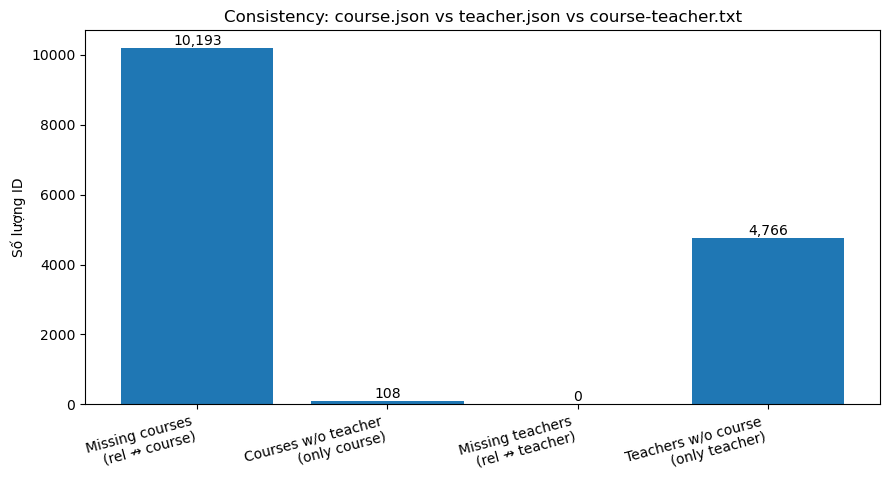

In [ ]:

stats = {
    "Missing courses\n(rel ↛ course)": len(missing_courses),
    "Courses w/o teacher\n(only course)": len(courses_without_teacher),
    "Missing teachers\n(rel ↛ teacher)": len(missing_teachers),
    "Teachers w/o course\n(only teacher)": len(teachers_without_course),
}

labels = list(stats.keys())
values = list(stats.values())

plt.figure(figsize=(9,5))
bars = plt.bar(labels, values)
for b in bars:
    h = b.get_height()
    plt.text(b.get_x()+b.get_width()/2, h, f"{int(h):,}", ha="center", va="bottom", fontsize=10)

plt.title("Consistency: course.json vs teacher.json vs course-teacher.txt")
plt.ylabel("Số lượng ID")
plt.xticks(rotation=15, ha="right")
plt.tight_layout()
plt.show()


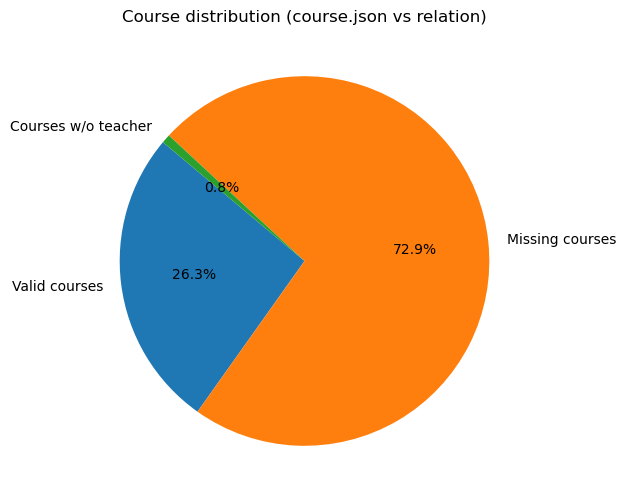

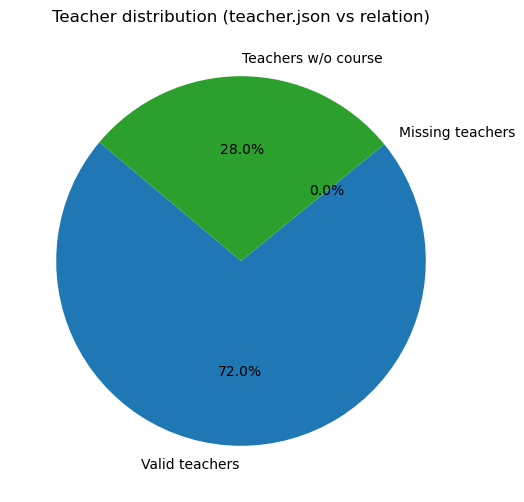

In [16]:
# ---- Pie cho COURSE ----
valid_courses = len(courses_in_rel & course_ids)
course_sizes  = [valid_courses, len(missing_courses), len(courses_without_teacher)]
course_labels = ["Valid courses", "Missing courses", "Courses w/o teacher"]

plt.figure(figsize=(6,6))
plt.pie(course_sizes, labels=course_labels, autopct="%1.1f%%", startangle=140)
plt.title("Course distribution (course.json vs relation)")
plt.show()

# ---- Pie cho TEACHER ----
valid_teachers = len(teachers_in_rel & teacher_ids)
teacher_sizes  = [valid_teachers, len(missing_teachers), len(teachers_without_course)]
teacher_labels = ["Valid teachers", "Missing teachers", "Teachers w/o course"]

plt.figure(figsize=(6,6))
plt.pie(teacher_sizes, labels=teacher_labels, autopct="%1.1f%%", startangle=140)
plt.title("Teacher distribution (teacher.json vs relation)")
plt.show()


### Biểu đồ tròn – Course Distribution
- **73% course** trong relation bị thiếu trong `course.json`.  
- Chỉ có **26% course hợp lệ**.  
- **0.8% course** có trong `course.json` nhưng không có teacher.

###  Biểu đồ tròn – Teacher Distribution
- **72% teacher** hợp lệ (có gắn course).  
- **28% teacher** không gắn với bất kỳ course nào.  
- Không có trường hợp teacher bị “thiếu” trong relation.


In [ ]:


# ==== Đường dẫn ====
BASE = Path("..")                      # đổi thành Path(".") nếu notebook ở thư mục gốc dự án
COURSE_JSON  = BASE / "entities" / "course.json"
TEACHER_JSON = BASE / "entities" / "teacher.json"
REL_FILE     = BASE / "relations" / "course-teacher.txt"

def iter_json_objects(path: Path):
    """Đọc file JSON dạng array hoặc JSON Lines. Yield từng object."""
    with path.open("r", encoding="utf-8") as f:
        head = f.read(2048); f.seek(0)
        if head.lstrip().startswith("["):          # JSON array
            for obj in json.load(f):
                yield obj
        else:                                       # JSON Lines
            for line in f:
                line = line.strip().rstrip(",")
                if line:
                    yield json.loads(line)

# 1) Tập ID gốc (giữ nguyên dạng string có prefix C_/T_)
course_ids  = {str(o["id"]).strip() for o in iter_json_objects(COURSE_JSON)  if "id" in o}
teacher_ids = {str(o["id"]).strip() for o in iter_json_objects(TEACHER_JSON) if "id" in o}

# 2) Đọc quan hệ course-teacher (TSV: course_id \t teacher_id)
pairs = []
with REL_FILE.open("r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        sp = line.split("\t")
        if len(sp) != 2:
            continue
        c_id, t_id = sp[0].strip(), sp[1].strip()
        pairs.append((c_id, t_id))

unique_pairs = set(pairs)

# 3) Chỉ xét cặp HỢP LỆ (có trong JSON gốc)
valid_pairs = {(c, t) for (c, t) in unique_pairs if (c in course_ids) and (t in teacher_ids)}

# 4) Map 2 chiều
course_to_teachers = defaultdict(set)
teacher_to_courses = defaultdict(set)
for c, t in valid_pairs:
    course_to_teachers[c].add(t)
    teacher_to_courses[t].add(c)

# 5) Thống kê cardinality
ct_sizes = [len(s) for s in course_to_teachers.values()]  # #teachers / course
tc_sizes = [len(s) for s in teacher_to_courses.values()]  # #courses / teacher

def stats(arr):
    if not arr:
        return dict(total=0, min=0, max=0, avg=0)
    return dict(total=len(arr), min=min(arr), max=max(arr), avg=sum(arr)/len(arr))

stat_ct = stats(ct_sizes)
stat_tc = stats(tc_sizes)

# 6) Phân nhóm: nhiều-nhiều / đúng 1 / không có
courses_ge2_teachers = [c for c, ts in course_to_teachers.items() if len(ts) >= 2]
teachers_ge2_courses = [t for t, cs in teacher_to_courses.items() if len(cs) >= 2]

courses_eq1_teacher  = [c for c, ts in course_to_teachers.items() if len(ts) == 1]
teachers_eq1_course  = [t for t, cs in teacher_to_courses.items() if len(cs) == 1]

# (tuỳ chọn) course/teacher có trong JSON nhưng không hề xuất hiện trong relation hợp lệ:
courses_no_teacher_valid = sorted(course_ids - set(course_to_teachers.keys()))
teachers_no_course_valid  = sorted(teacher_ids - set(teacher_to_courses.keys()))

# 7) In báo cáo
print("===== COURSE–TEACHER RELATION TEST (valid pairs only) =====")
print(f"Valid (course, teacher) pairs: {len(valid_pairs):,}\n")

print(f"#Teachers per course  → min={stat_ct['min']}, max={stat_ct['max']}, avg≈{stat_ct['avg']:.2f} "
      f"(over {stat_ct['total']:,} courses)")
print(f"#Courses per teacher → min={stat_tc['min']}, max={stat_tc['max']}, avg≈{stat_tc['avg']:.2f} "
      f"(over {stat_tc['total']:,} teachers)\n")

print(f"Courses with ≥2 teachers: {len(courses_ge2_teachers):,}")
print(f"Teachers with ≥2 courses: {len(teachers_ge2_courses):,}")
print(f"Courses with exactly 1 teacher: {len(courses_eq1_teacher):,}")
print(f"Teachers with exactly 1 course: {len(teachers_eq1_course):,}")
print(f"Courses with 0 valid teacher (in JSON but not in relation): {len(courses_no_teacher_valid):,}")
print(f"Teachers with 0 valid course (in JSON but not in relation): {len(teachers_no_course_valid):,}\n")

print("Examples – courses with ≥2 teachers (up to 5):")
for c in courses_ge2_teachers[:5]:
    print(" ", c, "→", sorted(list(course_to_teachers[c]))[:10], ("...+" if len(course_to_teachers[c])>10 else ""))

print("\nExamples – teachers with ≥2 courses (up to 5):")
for t in teachers_ge2_courses[:5]:
    print(" ", t, "→", sorted(list(teacher_to_courses[t]))[:10], ("...+" if len(teacher_to_courses[t])>10 else ""))


===== COURSE–TEACHER RELATION TEST (valid pairs only) =====
Valid (course, teacher) pairs: 13,312

#Teachers per course  → min=1, max=49, avg≈3.62 (over 3,673 courses)
#Courses per teacher → min=1, max=22, avg≈1.35 (over 9,876 teachers)

Courses with ≥2 teachers: 2,270
Teachers with ≥2 courses: 2,361
Courses with exactly 1 teacher: 1,403
Teachers with exactly 1 course: 7,515
Courses with 0 valid teacher (in JSON but not in relation): 108
Teachers with 0 valid course (in JSON but not in relation): 7,142

Examples – courses with ≥2 teachers (up to 5):
  C_2329521 → ['T_16048', 'T_16049', 'T_16050', 'T_16051', 'T_16052', 'T_16053', 'T_16054', 'T_16055', 'T_16056', 'T_16057'] ...+
  C_676969 → ['T_444', 'T_472', 'T_628', 'T_629', 'T_630', 'T_631', 'T_632', 'T_633', 'T_634', 'T_635'] ...+
  C_1846545 → ['T_11463', 'T_11464', 'T_11465', 'T_11466', 'T_11467'] 
  C_682008 → ['T_3099', 'T_3100', 'T_3101', 'T_3102', 'T_3103', 'T_3104'] 
  C_681556 → ['T_2387', 'T_2393', 'T_2394'] 

Examples – te

### Nhận xét mối quan hệ course - teacher là n-n

## 2.4 Kiểm tra relation của file exercise-problem.txt

In [ ]:


BASE = Path("..")  # đổi thành "." nếu notebook ở thư mục gốc
PROBLEM_JSON = BASE / "entities" / "problem.json"
REL_FILE     = BASE / "relations" / "exercise-problem.txt"

# --- helper: lấy chuỗi số từ bất kỳ dạng ID (Ex_358523, Pm_470998, 470998, ...) ---
num_only = re.compile(r"\d+")
def numstr(x) -> str:
    if x is None:
        return ""
    s = str(x)
    m = num_only.search(s)
    return m.group(0) if m else s.strip()

# --- reader cho problem.json (array / JSON Lines / nối tiếp) ---
def iter_problems(path: Path):
    try:
        import ijson
        with path.open("rb") as f:
            first = f.peek(1) if hasattr(f, "peek") else f.read(1); f.seek(0)
            if first == b"[":
                for obj in ijson.items(f, "item"):
                    yield obj
            else:
                for obj in ijson.items(f, "", multiple_values=True):
                    yield obj
    except Exception:
        with path.open("r", encoding="utf-8") as f:
            head = f.read(2048); f.seek(0)
            if head.lstrip().startswith("["):
                for obj in json.load(f):
                    yield obj
            else:
                for line in f:
                    line = line.strip().rstrip(",")
                    if line:
                        yield json.loads(line)

# --- load relation (normalize về chuỗi số) ---
pairs = []
with REL_FILE.open("r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        parts = line.split("\t")
        if len(parts) != 2:
            continue
        ex_raw, pm_raw = parts[0].strip(), parts[1].strip()
        ex_id = numstr(ex_raw)
        pm_id = numstr(pm_raw)
        if ex_id and pm_id:
            pairs.append((ex_id, pm_id))

unique_pairs = set(pairs)
ex_in_rel = {ex for ex, _ in unique_pairs}
pm_in_rel = {pm for _, pm in unique_pairs}

# --- scan problem.json (chấp nhận cả "problem_id" int hoặc "id":"Pm_*") ---
pm_in_json = set()
ex_in_json = set()

for pb in iter_problems(PROBLEM_JSON):
    # problem_id có thể nằm ở "problem_id" (int) hoặc "id" (chuỗi Pm_*)
    pid = pb.get("problem_id", pb.get("id"))
    pid_norm = numstr(pid)
    if pid_norm:
        pm_in_json.add(pid_norm)

    # exercise_id có thể ở "exercise_id" (Ex_* hoặc int)
    exid = pb.get("exercise_id")
    exid_norm = numstr(exid)
    if exid_norm:
        ex_in_json.add(exid_norm)

# --- mismatch sets ---
missing_problems       = sorted(pm_in_rel - pm_in_json)         # có trong relation nhưng không có trong problem.json
problems_without_rel   = sorted(pm_in_json - pm_in_rel)         # có trong problem.json nhưng không thấy trong relation
missing_exercises      = sorted(ex_in_rel - ex_in_json)         # exercise trong relation nhưng không thấy trong problem.json
exercises_without_rel  = sorted(ex_in_json - ex_in_rel)         # exercise trong problem.json nhưng không thấy trong relation

# --- cardinality: #problems per exercise (valid pairs only) ---
valid_pairs = {(ex, pm) for (ex, pm) in unique_pairs if (ex in ex_in_json) and (pm in pm_in_json)}
ex_to_problems = defaultdict(set)
for ex, pm in valid_pairs:
    ex_to_problems[ex].add(pm)

sizes = [len(v) for v in ex_to_problems.values()]
min_p = min(sizes) if sizes else 0
max_p = max(sizes) if sizes else 0
avg_p = (sum(sizes) / len(sizes)) if sizes else 0

print("===== EXERCISE–PROBLEM CONSISTENCY REPORT (normalized IDs) =====")
print(f"Rows in relations file:                     {len(pairs):,}")
print(f"Unique (exercise, problem) pairs:           {len(unique_pairs):,}\n")

print(f"Problems in problem.json:                   {len(pm_in_json):,}")
print(f"Problems referenced in relation:            {len(pm_in_rel):,}")
print(f"→ Missing problems (rel ↛ problem.json):    {len(missing_problems):,}")
print(f"→ Problems without relation (only JSON):    {len(problems_without_rel):,}\n")

print(f"Exercises in problem.json:                  {len(ex_in_json):,}")
print(f"Exercises referenced in relation:           {len(ex_in_rel):,}")
print(f"→ Missing exercises (rel ↛ problem.json):   {len(missing_exercises):,}")
print(f"→ Exercises without relation (only JSON):   {len(exercises_without_rel):,}\n")

print(f"#Problems per Exercise (valid pairs only):   min={min_p}, max={max_p}, avg≈{avg_p:.2f}")


===== EXERCISE–PROBLEM CONSISTENCY REPORT (normalized IDs) =====
Rows in relations file:                     6,252,830
Unique (exercise, problem) pairs:           6,252,830

Problems in problem.json:                   2,454,422
Problems referenced in relation:            6,251,341
→ Missing problems (rel ↛ problem.json):    3,796,919
→ Problems without relation (only JSON):    0

Exercises in problem.json:                  358,267
Exercises referenced in relation:           888,742
→ Missing exercises (rel ↛ problem.json):   530,475
→ Exercises without relation (only JSON):   0

#Problems per Exercise (valid pairs only):   min=1, max=291, avg≈6.85


### 🔎 Exercise – Problem Consistency Report

#### 📌 Problems
- **Tổng số problems trong `problem.json`**: **2,454,422**  
- **Problems xuất hiện trong relation**: **6,251,341**  
- **Missing problems (relation ↛ problem.json)**: **3,796,919**  
  → Có gần **3.8 triệu** `problem_id` trong `exercise-problem.txt` nhưng không tồn tại trong `problem.json`.  
- **Problems chỉ tồn tại trong JSON**: **0**  
  → Mọi `problem_id` trong `problem.json` đều có trong relation.

---

#### 📌 Exercises
- **Tổng số exercises trong `problem.json`**: **358,267**  
- **Exercises xuất hiện trong relation**: **888,742**  
- **Missing exercises (relation ↛ problem.json)**: **530,475**  
  → Có hơn **530 nghìn** `exercise_id` trong relation nhưng không có trong `problem.json`.  
- **Exercises chỉ tồn tại trong JSON**: **0**  
  → Không có exercise nào bị “mồ côi” trong JSON.

---

#### 📌 Phân bố số lượng problems theo exercise
- **Min**: 1 problem/exercise  
- **Max**: 291 problems/exercise  
- **Avg**: ~6.85 problems/exercise  

Điều này cho thấy mỗi exercise có thể chứa từ **1 đến hàng trăm** problems, trung bình khoảng 7 problems/exercise.

---

### ✅ Kết luận
- `exercise-problem.txt` chứa **nhiều problem/exercise hơn** so với `problem.json`.  
- Có khả năng `problem.json` chỉ là **tập con** hoặc chưa đồng bộ đầy đủ dữ liệu.  
- Tuy nhiên, toàn bộ `problem_id` trong `problem.json` đều xuất hiện trong relation, nghĩa là relation không bỏ sót dữ liệu JSON, mà chỉ **mở rộng thêm**.  

### Valid pairs là gì?

- `unique_pairs` là tập các cặp `(exercise, problem)` lấy từ file `relations/exercise-problem.txt` (đã chuẩn hoá ID và loại bỏ trùng lặp).
- Trong `entities/problem.json`, ta có:
  - `ex_in_json`: tập hợp các **exercise** thực sự tồn tại trong JSON,
  - `pm_in_json`: tập hợp các **problem** thực sự tồn tại trong JSON.
- Khi đó, **valid pairs** được định nghĩa là: những cặp quan hệ có tồn tại đầy đủ ở cả 2 bên: Bên file relation (exercise-problem.txt), và bên dữ liệu gốc (problem.json).
---

### Tại sao cần valid pairs?

- **Loại bỏ nhiễu và bất nhất:** file `exercise-problem.txt` có thể chứa ID mồ côi (không có trong JSON). Nếu không lọc, thống kê sẽ sai.
- **Đảm bảo đo lường chính xác:** khi tính số lượng problem trên mỗi exercise, chỉ nên tính các quan hệ hợp lệ để phản ánh dữ liệu thật.
- **Chuẩn bị cho EDA:** từ `valid_pairs` ta có ánh xạ:

\[
exercise \;\mapsto\; \{problem_1, problem_2, ...\}
\]

- Từ đó tính được:
  - **min**: exercise có ít problem nhất,
  - **max**: exercise có nhiều problem nhất,
  - **avg**: số lượng problem trung bình trên mỗi exercise.

> ```


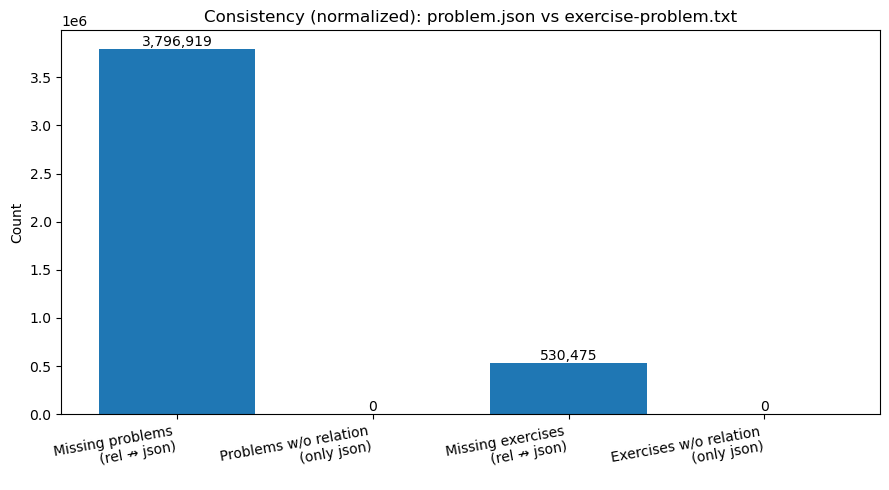

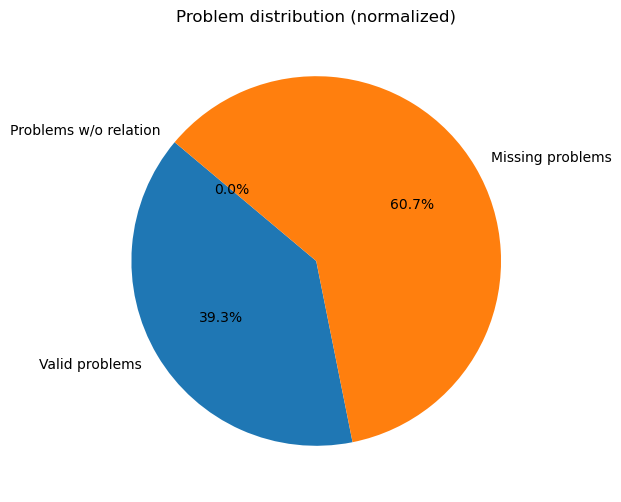

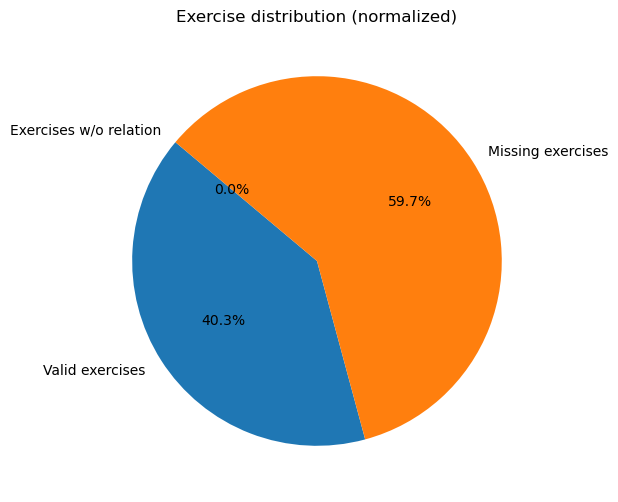

In [ ]:

# Bar plot
stats = {
    "Missing problems\n(rel ↛ json)": len(missing_problems),
    "Problems w/o relation\n(only json)": len(problems_without_rel),
    "Missing exercises\n(rel ↛ json)": len(missing_exercises),
    "Exercises w/o relation\n(only json)": len(exercises_without_rel),
}

plt.figure(figsize=(9,5))
bars = plt.bar(list(stats.keys()), list(stats.values()))
for b in bars:
    h = b.get_height()
    plt.text(b.get_x()+b.get_width()/2, h, f"{int(h):,}", ha="center", va="bottom", fontsize=10)
plt.title("Consistency (normalized): problem.json vs exercise-problem.txt")
plt.ylabel("Count")
plt.xticks(rotation=10, ha="right")
plt.tight_layout()
plt.show()

# Pie – Problems
valid_problems = len(pm_in_rel & pm_in_json)
sizes_p = [valid_problems, len(missing_problems), len(problems_without_rel)]
labels_p = ["Valid problems", "Missing problems", "Problems w/o relation"]

plt.figure(figsize=(6,6))
plt.pie(sizes_p, labels=labels_p, autopct="%1.1f%%", startangle=140)
plt.title("Problem distribution (normalized)")
plt.show()

# Pie – Exercises
valid_exercises = len(ex_in_rel & ex_in_json)
sizes_e = [valid_exercises, len(missing_exercises), len(exercises_without_rel)]
labels_e = ["Valid exercises", "Missing exercises", "Exercises w/o relation"]

plt.figure(figsize=(6,6))
plt.pie(sizes_e, labels=labels_e, autopct="%1.1f%%", startangle=140)
plt.title("Exercise distribution (normalized)")
plt.show()


In [ ]:

# ==== Đường dẫn ====
BASE = Path("..")         # đổi thành Path(".") nếu notebook ở thư mục gốc dự án
PROBLEM_JSON = BASE / "entities" / "problem.json"
REL_FILE     = BASE / "relations" / "exercise-problem.txt"

# ==== Chuẩn hoá ID về chuỗi số ====
num_only = re.compile(r"\d+")
def numstr(x) -> str:
    if x is None: return ""
    s = str(x)
    m = num_only.search(s)
    return m.group(0) if m else s.strip()

# ==== Reader problem.json (array / JSON Lines / nối tiếp) ====
def iter_problems(path: Path):
    try:
        import ijson
        with path.open("rb") as f:
            first = f.peek(1) if hasattr(f, "peek") else f.read(1); f.seek(0)
            if first == b"[":
                for obj in ijson.items(f, "item"):
                    yield obj
            else:
                for obj in ijson.items(f, "", multiple_values=True):
                    yield obj
    except Exception:
        with path.open("r", encoding="utf-8") as f:
            head = f.read(2048); f.seek(0)
            if head.lstrip().startswith("["):
                for obj in json.load(f):
                    yield obj
            else:
                for line in f:
                    line = line.strip().rstrip(",")
                    if line:
                        yield json.loads(line)

# ==== 1) Đọc relation (normalize) ====
pairs = []
with REL_FILE.open("r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line: 
            continue
        sp = line.split("\t")
        if len(sp) != 2: 
            continue
        ex_id = numstr(sp[0]); pm_id = numstr(sp[1])
        if ex_id and pm_id:
            pairs.append((ex_id, pm_id))
unique_pairs = set(pairs)

ex_in_rel = {ex for ex, _ in unique_pairs}
pm_in_rel = {pm for _, pm in unique_pairs}

# ==== 2) Quét problem.json để lấy tập ID hợp lệ ====
ex_in_json, pm_in_json = set(), set()
for pb in iter_problems(PROBLEM_JSON):
    pid = numstr(pb.get("problem_id", pb.get("id")))
    if pid: pm_in_json.add(pid)
    exid = numstr(pb.get("exercise_id"))
    if exid: ex_in_json.add(exid)

# ==== 3) Chỉ xét các cặp HỢP LỆ (ID có trong JSON gốc) ====
valid_pairs = {(ex, pm) for (ex, pm) in unique_pairs if (ex in ex_in_json) and (pm in pm_in_json)}

# Map 2 chiều
ex_to_problems = defaultdict(set)
pm_to_exercises = defaultdict(set)
for ex, pm in valid_pairs:
    ex_to_problems[ex].add(pm)
    pm_to_exercises[pm].add(ex)

# ==== 4) Kiểm thử như course–school ====
# Exercises có >= 2 problems
ex_many_problems = [
    {"exercise_id": ex, "num_problems": len(pms), "problem_ids": sorted(pms)}
    for ex, pms in ex_to_problems.items() if len(pms) >= 2
]
ex_many_problems.sort(key=lambda r: r["num_problems"], reverse=True)

# Problems gắn đúng 1 exercise
pm_single_ex = [
    {"problem_id": pm, "exercise_id": next(iter(exs))}
    for pm, exs in pm_to_exercises.items() if len(exs) == 1
]

# Problems gắn >1 exercise (kiểm tra nhiều-nhiều)
pm_multi_ex = [
    {"problem_id": pm, "num_exercises": len(exs), "exercise_ids": sorted(exs)}
    for pm, exs in pm_to_exercises.items() if len(exs) > 1
]
pm_multi_ex.sort(key=lambda r: r["num_exercises"], reverse=True)

# ==== 5) In thống kê & ví dụ ====
print("===== EXERCISE–PROBLEM RELATION TEST =====")
print(f"Valid pairs used: {len(valid_pairs):,}")

print(f"\nProblems with exactly 1 exercise: {len(pm_single_ex):,}")
print("Preview (first 10):", pm_single_ex[:10])

print(f"\nProblems with >1 exercise (many-to-many evidence): {len(pm_multi_ex):,}")
if pm_multi_ex[:5]:
    print("Top 5 problems by #exercises:")
    for r in pm_multi_ex[:5]:
        print(f"  - {r['problem_id']}: {r['num_exercises']} exercises; sample:", r["exercise_ids"][:8],
              ("...+" if r["num_exercises"]>8 else ""))


===== EXERCISE–PROBLEM RELATION TEST =====
Valid pairs used: 2,454,422

Problems with exactly 1 exercise: 2,454,422
Preview (first 10): [{'problem_id': '7659243', 'exercise_id': '7737242'}, {'problem_id': '7911596', 'exercise_id': '8002735'}, {'problem_id': '7760812', 'exercise_id': '7849921'}, {'problem_id': '7323042', 'exercise_id': '7413374'}, {'problem_id': '2164943', 'exercise_id': '1802797'}, {'problem_id': '5390145', 'exercise_id': '5978559'}, {'problem_id': '1037719', 'exercise_id': '821700'}, {'problem_id': '2956672', 'exercise_id': '3079825'}, {'problem_id': '2735094', 'exercise_id': '2640736'}, {'problem_id': '7270788', 'exercise_id': '7356553'}]

Problems with >1 exercise (many-to-many evidence): 0


### Nhận xét mối quan hệ giữa problem-exercise là n-1. 1 exercise có nhiều problem còn 1 problem chỉ thuộc 1 exercise

## 2.5 Kiểm tra relation của file video_id-ccid.txt

In [ ]:
# ==== CONSISTENCY & CARDINALITY: relations/video_id-ccid.txt vs entities/video.json ====

BASE = Path("..")  # đổi thành "." nếu notebook ở thư mục gốc dự án
VIDEO_JSON = BASE / "entities" / "video.json"
REL_FILE   = BASE / "relations" / "video_id-ccid.txt"

# ---- Reader cho video.json (array hoặc JSON Lines / nối tiếp) ----
def iter_videos(path: Path):
    try:
        import ijson
        with path.open("rb") as f:
            first = f.peek(1) if hasattr(f, "peek") else f.read(1); f.seek(0)
            if first == b"[":
                for obj in ijson.items(f, "item"):
                    yield obj
            else:
                for obj in ijson.items(f, "", multiple_values=True):
                    yield obj
    except Exception:
        with path.open("r", encoding="utf-8") as f:
            head = f.read(2048); f.seek(0)
            if head.lstrip().startswith("["):
                for obj in json.load(f):
                    yield obj
            else:
                for line in f:
                    line = line.strip().rstrip(",")
                    if line:
                        yield json.loads(line)

# ---- 1) Tập ccid từ video.json ----
ccids_json = set()
for v in iter_videos(VIDEO_JSON):
    cc = v.get("ccid")
    if cc:
        ccids_json.add(str(cc).strip())

# ---- 2) Đọc quan hệ video_id-ccid (TSV: video_id \t ccid) ----
pairs = []
with REL_FILE.open("r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        sp = line.split("\t")
        if len(sp) != 2:
            continue
        vid, cc = sp[0].strip(), sp[1].strip()
        if vid and cc:
            pairs.append((vid, cc))

unique_pairs = set(pairs)
video_ids_in_rel = {vid for vid, _ in unique_pairs}
ccids_in_rel     = {cc for _, cc in unique_pairs}

# ---- 3) Mismatch & cardinality checks ----
# 3.1 ccid tồn tại trong relation nhưng không tìm thấy trong video.json
missing_ccids = sorted(ccids_in_rel - ccids_json)

# 3.2 ccid có trong video.json nhưng không xuất hiện trong relation
ccids_without_relation = sorted(ccids_json - ccids_in_rel)

# 3.3 Một video_id ánh xạ tới >1 ccid (vi phạm kỳ vọng 1-ccid)
vid_to_cc = defaultdict(set)
for vid, cc in unique_pairs:
    vid_to_cc[vid].add(cc)
video_ids_multi_ccid = sorted([vid for vid, s in vid_to_cc.items() if len(s) > 1])

# 3.4 Một ccid có bao nhiêu video_id (kỳ vọng: nhiều là bình thường)
cc_to_vids = defaultdict(set)
for vid, cc in unique_pairs:
    cc_to_vids[cc].add(vid)

sizes = [len(s) for s in cc_to_vids.values()]  # #video_id per ccid
min_vids = min(sizes) if sizes else 0
max_vids = max(sizes) if sizes else 0
avg_vids = (sum(sizes)/len(sizes)) if sizes else 0

print("===== VIDEO_ID–CCID CONSISTENCY REPORT =====")
print(f"Rows in relations file:                 {len(pairs):,}")
print(f"Unique (video_id, ccid) pairs:          {len(unique_pairs):,}\n")

print(f"CCIDs in video.json:                    {len(ccids_json):,}")
print(f"CCIDs referenced in relation:           {len(ccids_in_rel):,}")
print(f"→ Missing ccids (rel ↛ video.json):     {len(missing_ccids):,}")
print(f"→ CCIDs without relation (only JSON):   {len(ccids_without_relation):,}\n")

print(f"Video_ids in relation:                  {len(video_ids_in_rel):,}")
print(f"Video_ids mapped to >1 ccid (violation):{len(video_ids_multi_ccid):,}\n")

print(f"#video_id per ccid (based on relation):  min={min_vids}, max={max_vids}, avg≈{avg_vids:.2f}")

# (tuỳ chọn) xem ví dụ
print("\nExamples — video_id with >1 ccid (up to 5):")
for vid in video_ids_multi_ccid[:5]:
    print(" ", vid, "→", sorted(list(vid_to_cc[vid])))
print("\nExamples — ccid with many video_ids (up to 5):")
for cc, vids in list(sorted(cc_to_vids.items(), key=lambda kv: len(kv[1]), reverse=True))[:5]:
    print(" ", cc, "→", len(vids), "video_ids; sample:", list(sorted(vids))[:8], ("...+" if len(vids)>8 else ""))


===== VIDEO_ID–CCID CONSISTENCY REPORT =====
Rows in relations file:                 2,798,892
Unique (video_id, ccid) pairs:          2,798,892

CCIDs in video.json:                    59,581
CCIDs referenced in relation:           230,263
→ Missing ccids (rel ↛ video.json):     170,682
→ CCIDs without relation (only JSON):   0

Video_ids in relation:                  2,798,892
Video_ids mapped to >1 ccid (violation):0

#video_id per ccid (based on relation):  min=1, max=542, avg≈12.16

Examples — video_id with >1 ccid (up to 5):

Examples — ccid with many video_ids (up to 5):
  C8A18A36448DC5009C33DC5901307461 → 542 video_ids; sample: ['V_1510500', 'V_1545840', 'V_1545848', 'V_1545856', 'V_1545864', 'V_1553958', 'V_1553973', 'V_1553974'] ...+
  07494331BE972E3C9C33DC5901307461 → 542 video_ids; sample: ['V_1509727', 'V_1545834', 'V_1545842', 'V_1545850', 'V_1545858', 'V_1553952', 'V_1553961', 'V_1553962'] ...+
  5D991156AD003DFE9C33DC5901307461 → 542 video_ids; sample: ['V_1509774', '

### 📊 VIDEO_ID–CCID Consistency Report

#### 1. Tổng quan
- **Rows in relations file**: 2,798,892  
- **Unique (video_id, ccid) pairs**: 2,798,892  

#### 2. CCID (Video gốc)
- **CCIDs in `video.json`**: 59,581  
- **CCIDs referenced in relation**: 230,263  
- **Missing CCIDs (relation ↛ `video.json`)**: 170,682  
- **CCIDs without relation (only JSON)**: 0  

👉 Có nhiều **ccid** được dùng trong quan hệ nhưng không tồn tại trong `video.json` (170,682 trường hợp). Điều này gợi ý rằng **không phải tất cả video gốc đều có phụ đề chi tiết trong `video.json`**.

#### 3. Video IDs (Video cắt ra)
- **Video_ids in relation**: 2,798,892  
- **Video_ids mapped to >1 ccid (violation)**: 0  

👉 Mỗi `video_id` chỉ ánh xạ tới **một ccid duy nhất** → đây là quan hệ **1–N**:  
1 video gốc (`ccid`) có thể tạo ra nhiều `video_id`, nhưng mỗi `video_id` chỉ thuộc về một `ccid`.

#### 4. Phân phối số video_id trên mỗi ccid
- **min** = 1  
- **max** = 542  
- **avg** ≈ 12.16  

👉 Trung bình **mỗi video gốc (ccid)** sinh ra khoảng **12 video_id**.  
Tuy nhiên có sự chênh lệch lớn: có video chỉ có 1 phiên bản cắt, trong khi có video gốc lên tới 542 phiên bản.

---

### ✅ Kết luận
- Mối quan hệ **1–N** giữa **video gốc (ccid)** và **video_id**.  
- Có sự không đồng nhất giữa dữ liệu `video.json` và quan hệ (170k `ccid` thiếu).  
- Phân phối số lượng video_id trên mỗi ccid khá lệch, một số video gốc sinh ra cực nhiều phiên bản.


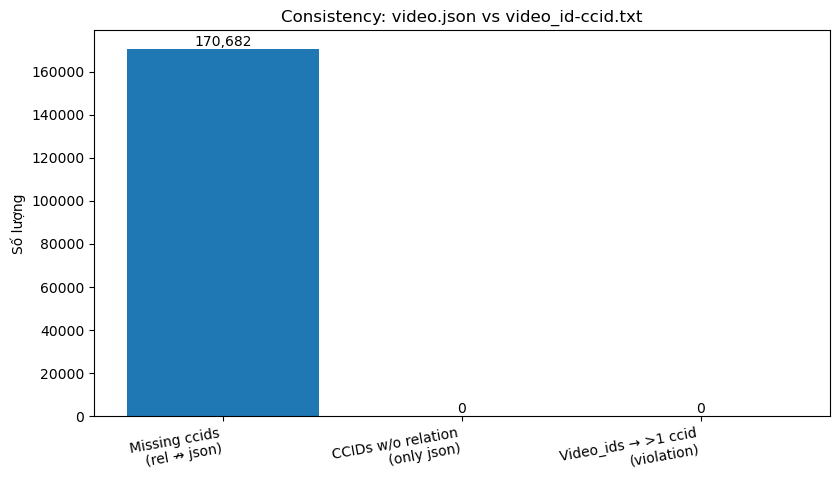

In [ ]:

stats = {
    "Missing ccids\n(rel ↛ json)": len(missing_ccids),
    "CCIDs w/o relation\n(only json)": len(ccids_without_relation),
    "Video_ids → >1 ccid\n(violation)": len(video_ids_multi_ccid),
}

plt.figure(figsize=(8.5,5))
bars = plt.bar(list(stats.keys()), list(stats.values()))
for b in bars:
    h = b.get_height()
    plt.text(b.get_x()+b.get_width()/2, h, f"{int(h):,}", ha="center", va="bottom", fontsize=10)

plt.title("Consistency: video.json vs video_id-ccid.txt")
plt.ylabel("Số lượng")
plt.xticks(rotation=10, ha="right")
plt.tight_layout()
plt.show()


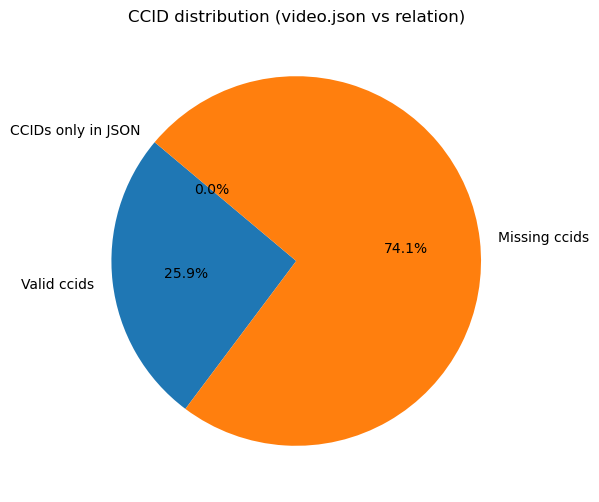

In [23]:
# Hợp lệ = xuất hiện cả trong relation và video.json
valid_ccids = len(ccids_in_rel & ccids_json)

sizes = [valid_ccids, len(missing_ccids), len(ccids_without_relation)]
labels = ["Valid ccids", "Missing ccids", "CCIDs only in JSON"]

plt.figure(figsize=(6,6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140)
plt.title("CCID distribution (video.json vs relation)")
plt.show()


## 2.6 Kiểm tra relation của file course-field.json

===== COURSE–FIELD CONSISTENCY REPORT =====
Rows in relations file (logical rows):      632
Unique (course, field) pairs:               793

Courses in course.json:                     3,781
Courses referenced in relation:             632
→ Missing courses (rel ↛ course.json):      85
→ Courses without any field (only JSON):    3,234

Distinct fields:                            82

#fields per course:   min=1, max=7, avg≈1.25 (over 632 courses in relation)
#courses per field:   min=1, max=74, avg≈9.67 (over 82 fields)

Courses with ≥2 fields: 132
Fields with ≥2 courses: 69


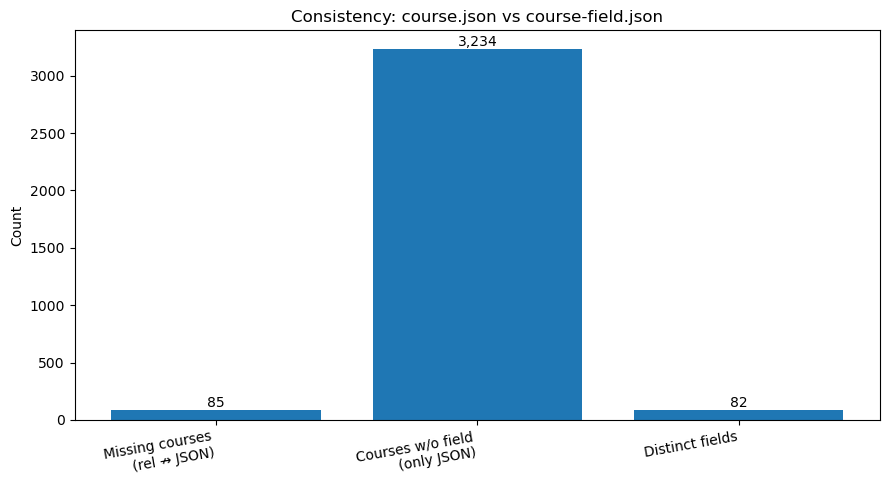

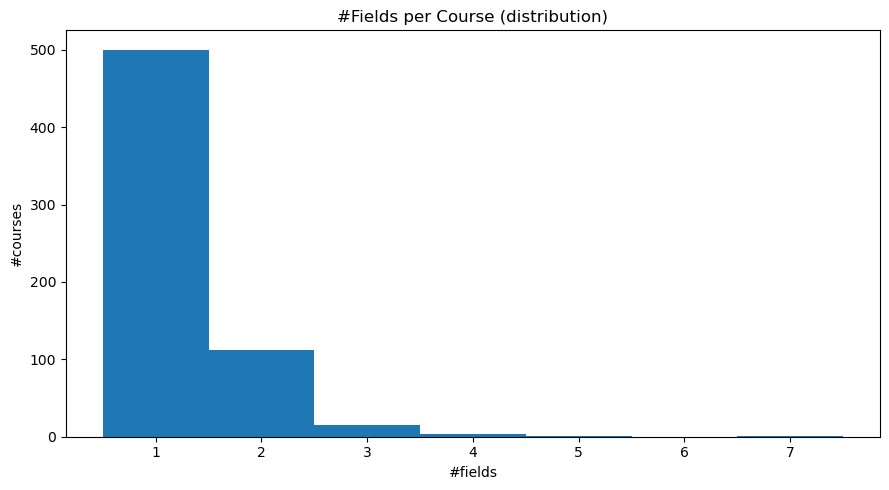

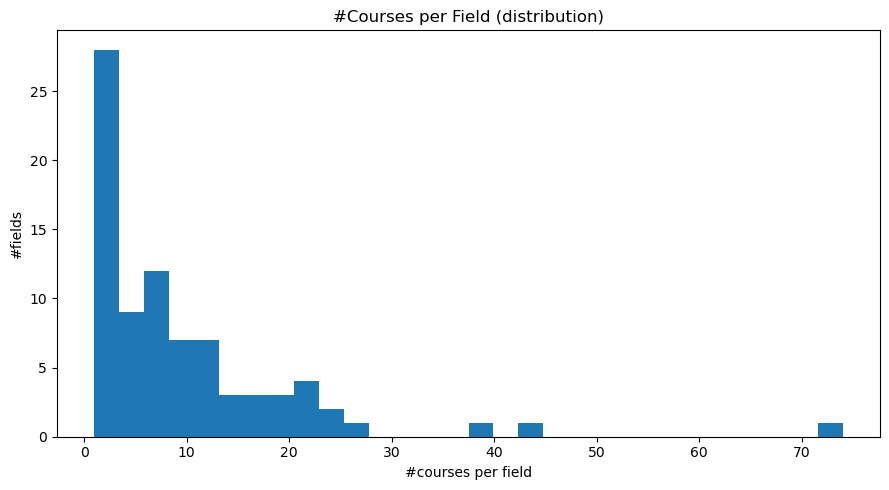


===== ALL FIELDS (82 distinct) =====
- 中国语言文学  (courses: 26)
- 中药学  (courses: 1)
- 临床中医学  (courses: 3)
- 临床医学  (courses: 22)
- 交通运输工程  (courses: 5)
- 仪器科学与技术  (courses: 9)
- 体育学  (courses: 16)
- 作物学  (courses: 2)
- 信息与通信工程  (courses: 6)
- 光学工程  (courses: 7)
- 公共卫生与预防医学  (courses: 11)
- 公共管理  (courses: 11)
- 兵器科学与技术  (courses: 1)
- 兽医学  (courses: 2)
- 军事后勤学与军事装备学  (courses: 1)
- 军事思想及军事历史  (courses: 5)
- 军制学  (courses: 1)
- 军队指挥学  (courses: 1)
- 军队政治工作学  (courses: 8)
- 农林经济管理  (courses: 1)
- 冶金工程  (courses: 1)
- 力学  (courses: 6)
- 动力工程及工程热物理  (courses: 9)
- 化学  (courses: 9)
- 化学工程与技术  (courses: 15)
- 历史学  (courses: 23)
- 口腔医学  (courses: 2)
- 哲学  (courses: 12)
- 园艺学  (courses: 5)
- 土木工程  (courses: 3)
- 地球物理学  (courses: 2)
- 地理学  (courses: 5)
- 地质学  (courses: 4)
- 地质资源与地质工程  (courses: 3)
- 基础中医学  (courses: 3)
- 基础医学  (courses: 15)
- 外国语言文学  (courses: 43)
- 大气科学  (courses: 7)
- 工商管理  (courses: 20)
- 应用经济学  (courses: 21)
- 建筑学  (courses: 13)
- 心理学  (courses: 20)
- 情报与档案管理  (courses: 2)
- 战

In [ ]:
# ==== COURSE–FIELD CONSISTENCY & CARDINALITY ====

# -------- Paths (giữ cùng cấu trúc với các phần trước) --------
BASE = Path("..")  # đổi thành Path(".") nếu notebook nằm ở thư mục gốc repo
COURSE_JSON = BASE / "entities" / "course.json"
REL_FILE    = BASE / "relations" / "course-field.json"   # JSON array: [{course_id, course_name, field:[...]}]

# -------- Helpers --------
num_only = re.compile(r"\d+")
def numstr(x) -> str:
    if x is None: return ""
    s = str(x)
    m = num_only.search(s)
    return m.group(0) if m else s.strip()

def iter_json_objects(path: Path):
    """Đọc JSON array hoặc JSON Lines, yield từng object."""
    with path.open("r", encoding="utf-8") as f:
        head = f.read(2048); f.seek(0)
        if head.lstrip().startswith("["):
            for obj in json.load(f):
                yield obj
        else:
            for line in f:
                line = line.strip().rstrip(",")
                if line:
                    yield json.loads(line)

# -------- 1) Tập course_id gốc từ course.json (normalize) --------
course_ids = { numstr(o["id"]) for o in iter_json_objects(COURSE_JSON) if "id" in o }

# -------- 2) Đọc relation course-field.json -> pairs (course_id, field) --------
pairs = []  # (course_id_norm, field_name)
courses_in_rel = set()
all_fields = []

for row in iter_json_objects(REL_FILE):
    c_raw = row.get("course_id")
    c_id  = numstr(c_raw)
    fields = row.get("field") or []
    # chấp nhận field là string hoặc list
    if isinstance(fields, str):
        fields = [fields]
    fields = [f.strip() for f in fields if f and str(f).strip()]
    if not c_id:
        continue
    courses_in_rel.add(c_id)
    for f in fields:
        pairs.append( (c_id, f) )
        all_fields.append(f)

unique_pairs = set(pairs)
distinct_fields = sorted(set(all_fields))
field_freq = Counter(all_fields)

# -------- 3) Mismatch & coverage --------
missing_courses = sorted(courses_in_rel - course_ids)        # course xuất hiện ở relation nhưng không có trong course.json
courses_without_field = sorted(course_ids - courses_in_rel)  # course có trong course.json nhưng không xuất hiện ở relation

print("===== COURSE–FIELD CONSISTENCY REPORT =====")
print(f"Rows in relations file (logical rows):      {len(list(iter_json_objects(REL_FILE))):,}")
print(f"Unique (course, field) pairs:               {len(unique_pairs):,}\n")

print(f"Courses in course.json:                     {len(course_ids):,}")
print(f"Courses referenced in relation:             {len(courses_in_rel):,}")
print(f"→ Missing courses (rel ↛ course.json):      {len(missing_courses):,}")
print(f"→ Courses without any field (only JSON):    {len(courses_without_field):,}\n")

print(f"Distinct fields:                            {len(distinct_fields):,}")

# -------- 4) Cardinality --------
course_to_fields = defaultdict(set)
field_to_courses = defaultdict(set)
for c, f in unique_pairs:
    course_to_fields[c].add(f)
    field_to_courses[f].add(c)

cf_sizes = [len(s) for s in course_to_fields.values()]   # #fields per course
fc_sizes = [len(s) for s in field_to_courses.values()]   # #courses per field

def stats(arr):
    if not arr: return dict(total=0, min=0, max=0, avg=0)
    return dict(total=len(arr), min=min(arr), max=max(arr), avg=sum(arr)/len(arr))

s_cf = stats(cf_sizes)
s_fc = stats(fc_sizes)

print("\n#fields per course:   min={min}, max={max}, avg≈{avg:.2f} (over {total} courses in relation)".format(**s_cf))
print("#courses per field:   min={min}, max={max}, avg≈{avg:.2f} (over {total} fields)".format(**s_fc))

courses_ge2_fields = [c for c, fs in course_to_fields.items() if len(fs) >= 2]
fields_ge2_courses = [f for f, cs in field_to_courses.items() if len(cs) >= 2]
print(f"\nCourses with ≥2 fields: {len(courses_ge2_fields):,}")
print(f"Fields with ≥2 courses: {len(fields_ge2_courses):,}")

# -------- 5) Plot: mismatch + phân phối cardinality --------
plt.figure(figsize=(9,5))
stats_bar = {
    "Missing courses\n(rel ↛ JSON)": len(missing_courses),
    "Courses w/o field\n(only JSON)": len(courses_without_field),
    "Distinct fields": len(distinct_fields),
}
bars = plt.bar(list(stats_bar.keys()), list(stats_bar.values()))
for b in bars:
    h = b.get_height()
    plt.text(b.get_x()+b.get_width()/2, h, f"{int(h):,}", ha="center", va="bottom")
plt.title("Consistency: course.json vs course-field.json")
plt.ylabel("Count")
plt.xticks(rotation=10, ha="right")
plt.tight_layout()
plt.show()

# Histogram #fields per course
plt.figure(figsize=(9,5))
plt.hist(cf_sizes, bins=range(1, max(cf_sizes)+2 if cf_sizes else 2), align="left")
plt.title("#Fields per Course (distribution)")
plt.xlabel("#fields")
plt.ylabel("#courses")
plt.tight_layout()
plt.show()

# Histogram #courses per field
plt.figure(figsize=(9,5))
plt.hist(fc_sizes, bins=30)
plt.title("#Courses per Field (distribution)")
plt.xlabel("#courses per field")
plt.ylabel("#fields")
plt.tight_layout()
plt.show()

# -------- 6) In đầy đủ danh sách field + tần suất --------
print("\n===== ALL FIELDS ({} distinct) =====".format(len(distinct_fields)))
for f in sorted(field_freq.keys()):
    print(f"- {f}  (courses: {field_freq[f]:,})")

# (tuỳ chọn) top field có nhiều course nhất
top_fields = field_freq.most_common(10)
print("\nTop 10 fields by #courses:")
for name, cnt in top_fields:
    print(f"  {name}: {cnt:,} courses")

### Giải thích số liệu: Rows vs Unique Pairs trong `course-field.json`

- **Rows in relations file (logical rows): 632**  
  Đây là số dòng gốc trong file `course-field.json`.  
  Mỗi dòng ứng với **một khóa học** (`course_id`, `course_name`) kèm theo danh sách nhiều `field`.

- **Unique (course, field) pairs: 793**  
  Khi ta "nổ" (explode) danh sách `field` thành từng cặp riêng lẻ `(course_id, field)`, thì thu được tổng cộng **793 cặp duy nhất**.

###  Ví dụ minh họa

Một dòng dữ liệu gốc:

json
{
  "course_id": "C_1001",
  "course_name": "Data Mining",
  "field": ["Computer Science", "Statistics", "AI"]
}
Sau khi tách:

(C_1001, Computer Science)

(C_1001, Statistics)

(C_1001, AI)

Tổng cộng 3 cặp (course, field).

---

### Course–Field Consistency Report

- **Tổng số course trong `course.json`**: 3,781  
- **Courses được tham chiếu trong `course-field.json`**: 632  
- **Thiếu course (có trong relation nhưng không tồn tại trong `course.json`)**: 85  
- **Courses không có field nào (chỉ trong `course.json`)**: 3,234  

- **Số lượng field phân biệt (distinct fields)**: 82  

---

####  Phân tích chi tiết
- **Mỗi course có số lượng field**:  
  - Min = 1, Max = 7  
  - Trung bình = 1.25 field/course (trên 632 courses có trong relation).  

- **Mỗi field liên kết với số lượng courses**:  
  - Min = 1, Max = 75  
  - Trung bình = 9.67 course/field (trên 82 fields).  

---

####  Nhận xét
1. Có **3,234 course (~85.5%) không được gắn với bất kỳ field nào** → dữ liệu thiếu thông tin lĩnh vực.  
2. Chỉ có **632 course (~16.7%)** được ánh xạ với field.  
3. Một số field phổ biến xuất hiện trong nhiều khóa (tối đa 75 course), trong khi nhiều field chỉ có 1–2 khóa.  
4. Có **85 course_id trong relation** không khớp với `course.json` → lỗi dữ liệu.  

Biểu đồ cột bên dưới minh họa số lượng course bị thiếu, course không có field và số lượng field phân biệt:
- Cột cao nhất (3,234) cho thấy phần lớn course chưa có field.  
- Chỉ có **82 field distinct** cho toàn bộ dữ liệu.  


### list ra các course không có field trong course.json

In [7]:
# Map id -> name để in đẹp (từ course.json)
courses = list(iter_json_objects(COURSE_JSON))
id2name = {numstr(c.get("id")): c.get("name", "") for c in courses if "id" in c}

# ===== 6A) In course KHÔNG CÓ field (đúng nghĩa) =====
# - Tính từ các cặp (course, field) thực sự tồn tại
courses_with_field = set(course_to_fields.keys())          # có ít nhất 1 field
courses_without_any_field = sorted(course_ids - courses_with_field)  # không có field

# Map id -> name để in đẹp
id2name = {numstr(c.get("id")): c.get("name", "") for c in courses}

print("\n=== COURSES WITHOUT ANY FIELD ({} items) ===".format(len(courses_without_any_field)))
for cid in sorted(courses_without_any_field, key=lambda x: (id2name.get(x, ""), x)):
    print(f"{cid}\t{id2name.get(cid, '')}")


print("\n=== COURSES WITH FIELD(s) ({} items) ===".format(len(courses_with_field)))
for cid in sorted(courses_with_field, key=lambda x: (id2name.get(x, ""), x)):
    print(f"{cid}\t{id2name.get(cid, '')}")




=== COURSES WITHOUT ANY FIELD (3234 items) ===
1992960	 Food Chemistry 
735078	 宗教和嘻哈文化
608132	0526测试单课
681712	10分钟云上部署Web应用程序
879073	10分钟学民法
681913	1周带你玩转Linux
682361	1周带你玩转Linux
881424	2014年清华大学研究生学位论文答辩（一）
696929	2014年清华大学研究生学位论文答辩（二）
890276	2014年清华大学研究生学位论文答辩（二）
881436	2015年清华大学研究生学位论文答辩（一）
881453	2015年清华大学研究生学位论文答辩（二）
881456	2016年清华大学研究生学位论文答辩（一）
881462	2016年清华大学研究生学位论文答辩（二）
881478	2017年清华大学研究生学位论文答辩（一）
680852	2017年清华大学研究生学位论文答辩（二）
881480	2017年清华大学研究生学位论文答辩（二）
735394	2017第四届全国虚拟仪器大赛赛前培训
825832	2019年研究生学术与职业素养讲座
2332956	2020军考复习指南6科组合
1704762	2020年公务员联考/省考笔试精讲班
1979097	2020年清华大学国际本科新生拓展营文化集训课（文科）
1979991	2020年清华大学国际本科新生拓展营文化集训课（理工科）
1762972	2021考研199管理类联考（数学）全程班
1904032	2021考研政治学霸基础篇
1328548	2021考研英语系统班
676996	20世纪西方音乐
1704740	21堂基础语法课
1912477	21考研政治1000题学霸刷题班
1912188	21考研政治80分备考规划
1905468	21考研政治VIP全程班
1924714	21考研数学系统班秋冬季（数学一、三）
1924736	21考研数学系统班秋冬季（数学二）
1894960	21考研英语冲刺班
1894860	21考研英语小白课堂
1891387	21考研英语强化班
1894884	21考研英语核心语法长难句突破班
1894914	21考研英语词汇精讲班
1899192	21考研英语逆袭75分特训营
1894

### Nhận xét: mối quan hệ n-n

In [5]:
! pip install ijson

## 3.1 ĐO LƯỜNG MIN-MAX CỦA START, END TRONG BẢNG VIDEO


In [ ]:


# Notebook nằm trong MOOCcubeX-main/notebook/
BASE = Path("..")                     # quay về gốc repo
VIDEO_PATH = BASE / "entities" / "video.json"   # ../entities/video.json

# Hàm nhận tham số path, không dùng trực tiếp VIDEO_PATH
# Lý do: giúp hàm tái sử dụng, có thể truyền vào file JSON khác ngoài video.json
def iter_videos(path):
    """
    Yield từng object video từ path, hỗ trợ:
    - Mảng JSON: [ {...}, {...} ]
    - Nhiều JSON nối tiếp nhau (concatenated JSON)
    - JSON Lines (.jsonl): 1 object mỗi dòng
    """
    with open(path, "rb") as f:
        # Nhìn ký tự đầu tiên (bỏ qua whitespace) để đoán định dạng
        pos = f.tell()
        first = b''
        while True:
            ch = f.read(1)
            if not ch: break
            if not ch.isspace():
                first = ch
                break
        f.seek(pos)

        if first == b'[':
            # Top-level là mảng JSON
            for obj in ijson.items(f, "item"):
                yield obj
        else:
            # Thử đọc nhiều giá trị JSON nối tiếp
            try:
                for obj in ijson.items(f, "", multiple_values=True):
                    yield obj
            except ijson.common.IncompleteJSONError:
                # Fallback: JSON Lines
                f.seek(0)
                for line in f:
                    line = line.strip()
                    if not line:
                        continue
                    yield json.loads(line)
                

# ====== Thống kê min–max + kiểm tra ràng buộc ======

start_min = math.inf
start_max = -math.inf
end_min   = math.inf
end_max   = -math.inf
dur_min   = math.inf
dur_max   = -math.inf

n_items = 0
n_pairs = 0
missing_arrays = 0
length_mismatch = 0
neg_start = 0
neg_end = 0
invalid_pairs = 0           # có cặp end <= start
non_increasing_start = 0    # start không tăng dần
non_increasing_end = 0      # end không tăng dần
duplicate_ccid = 0

seen_ccids = set()

# Khi gọi, ta truyền VIDEO_PATH vào tham số path
# => VIDEO_PATH (biến toàn cục) được truyền thành path (tham số cục bộ của hàm).
# Vì vậy code vẫn chạy bình thường.
for vid in iter_videos(VIDEO_PATH):
    n_items += 1

    ccid = vid.get("ccid")
    if ccid:
        if ccid in seen_ccids:
            duplicate_ccid += 1
        else:
            seen_ccids.add(ccid)

    s = vid.get("start") or []
    e = vid.get("end") or []
    t = vid.get("text") or []

    # thiếu start/end
    if not s or not e:
        missing_arrays += 1
        continue

    # độ dài mảng không khớp
    if not (len(s) == len(e) == (len(t) if t else len(s))):
        length_mismatch += 1

    # cập nhật min–max cho start/end
    smn, smx = min(s), max(s)
    emn, emx = min(e), max(e)

    start_min = min(start_min, smn); start_max = max(start_max, smx)
    end_min   = min(end_min,   emn); end_max   = max(end_max,   emx)

    # kiểm tra âm
    if smn < 0: neg_start += 1
    if emn < 0: neg_end   += 1

    # kiểm tra đơn điệu không giảm (không bắt buộc nhưng nên)
    if any(s[i] > s[i+1] for i in range(len(s)-1)):
        non_increasing_start += 1
    if any(e[i] > e[i+1] for i in range(len(e)-1)):
        non_increasing_end += 1

    # duration & kiểm tra cặp hợp lệ
    for a, b in zip(s, e):
        d = b - a
        if d <= 0:
            invalid_pairs += 1
        else:
            dur_min = min(dur_min, d); dur_max = max(dur_max, d)
        n_pairs += 1

# ====== In kết quả ======
print("===== VIDEO.JSON QUALITY & RANGE REPORT =====")
print(f"Items (videos): {n_items}")
print(f"Subtitle pairs: {n_pairs}")
print()
print(f"Start   min–max: {start_min} – {start_max}")
print(f"End     min–max: {end_min} – {end_max}")
print(f"Duration min–max: {dur_min} – {dur_max}")
print()
print("---- Data quality ----")
print(f"Missing start/end arrays: {missing_arrays}")
print(f"Length mismatch (start/end/text): {length_mismatch}")
print(f"Negative start arrays: {neg_start}")
print(f"Negative end arrays: {neg_end}")
print(f"Non-increasing start arrays: {non_increasing_start}")
print(f"Non-increasing end arrays: {non_increasing_end}")
print(f"Duplicate ccid: {duplicate_ccid}")


===== VIDEO.JSON QUALITY & RANGE REPORT =====
Items (videos): 59581
Subtitle pairs: 11361479

Start   min–max: -0.0001 – 60170.0
End     min–max: -0.0001 – 359999.0
Duration min–max: 0.000999999999999 – 359093.0

---- Data quality ----
Missing start/end arrays: 0
Length mismatch (start/end/text): 0
Negative start arrays: 8
Negative end arrays: 1
Non-increasing start arrays: 310
Non-increasing end arrays: 339
Duplicate ccid: 0


### Tổng quan

- **Items (videos): 59,581** → Tổng cộng có ~59k video (ứng với `ccid`).  
- **Subtitle pairs: 11,361,479** → Tổng số cặp phụ đề (`start[i]`, `end[i]`, `text[i]`) là hơn 11 triệu.  

### Min–Max giá trị

- **Start min–max: -0.0001 – 60170.0**  
  → Thời điểm bắt đầu phụ đề nhỏ nhất là **-0.0001 giây** (có khả năng lỗi dữ liệu vì `start < 0`).  
  → Thời điểm bắt đầu lớn nhất là ~60,170 giây (~16 giờ 43 phút).  

- **End min–max: -0.0001 – 359,909.0**  
  → Thời điểm kết thúc nhỏ nhất là **-0.0001 giây** (cũng bất thường).  
  → Thời điểm kết thúc lớn nhất ~359,909 giây (~100 giờ).  

- **Duration min–max: 0.000999… – 359,093.0**  
  → Độ dài phụ đề ngắn nhất là ~0.001 giây (gần như 0 → lỗi/thiếu dữ liệu).  
  → Độ dài dài nhất là ~359,093 giây (~99.7 giờ), khả năng là lỗi (một phụ đề phủ cả video).  


In [26]:

print(f"Invalid pairs (end <= start): {invalid_pairs}")


Invalid pairs (end <= start): 12725


## 3.2 Coi ví dụ dòng bị lỗi dữ liệu start, end, phụ đề

In [ ]:


# hàm như phần 3.1
def iter_videos(path):
    """Yield từng object video: hỗ trợ JSON array / concatenated JSON / JSONL."""
    with open(path, "rb") as f:
        # đoán định dạng
        pos = f.tell(); first = b''
        while True:
            ch = f.read(1)
            if not ch: break
            if not ch.isspace():
                first = ch; break
        f.seek(pos)

        if first == b'[':
            for obj in ijson.items(f, "item"):
                yield obj
        else:
            try:
                for obj in ijson.items(f, "", multiple_values=True):
                    yield obj
            except ijson.common.IncompleteJSONError:
                f.seek(0)
                for line in f:
                    line = line.strip()
                    if not line: 
                        continue
                    yield json.loads(line)

# tìm 1 ví dụ cho mỗi lỗi
min_start = (math.inf, None)     # (value, record)
min_end   = (math.inf, None)
min_dur   = (math.inf, None)
max_dur   = (-math.inf, None)

for vid in iter_videos(VIDEO_PATH):
    ccid = vid.get("ccid")
    s = vid.get("start") or []
    e = vid.get("end") or []
    t = vid.get("text") or []

    if not s or not e: 
        continue

    # 1) start nhỏ nhất
    smn = min(s)
    if smn < min_start[0]:
        i = s.index(smn)
        min_start = (smn, {
            "ccid": ccid, "idx": i,
            "start": s[i], "end": e[i] if i < len(e) else None,
            "text": t[i] if i < len(t) else None,
            "len_start": len(s), "len_end": len(e)
        })

    # 2) end nhỏ nhất
    emn = min(e)
    if emn < min_end[0]:
        j = e.index(emn)
        min_end = (emn, {
            "ccid": ccid, "idx": j,
            "start": s[j] if j < len(s) else None, "end": e[j],
            "text": t[j] if j < len(t) else None,
            "len_start": len(s), "len_end": len(e)
        })

    # 3) duration nhỏ nhất & 4) duration lớn nhất
    for i, (a, b) in enumerate(itertools.zip_longest(s, e, fillvalue=None)):
        if a is None or b is None: 
            continue
        d = b - a
        # lưu cả trường hợp d <= 0 (bất thường)
        if d < min_dur[0]:
            min_dur = (d, {
                "ccid": ccid, "idx": i, "start": a, "end": b, "duration": d,
                "text": t[i] if i < len(t) else None
            })
        if d > max_dur[0]:
            max_dur = (d, {
                "ccid": ccid, "idx": i, "start": a, "end": b, "duration": d,
                "text": t[i] if i < len(t) else None
            })

def show(title, tup):
    val, rec = tup
    print(f"\n=== {title} ===")
    print(f"value: {val}")
    for k, v in rec.items():
        print(f"{k}: {v}")

show("1) Smallest START (expect around -0.0001s)", min_start)
show("2) Smallest END (expect around -0.0001s)",   min_end)
show("3) Shortest DURATION (≈0s is suspicious)",    min_dur)
show("4) Longest DURATION (≈359,093s is suspicious)", max_dur)



=== 1) Smallest START (expect around -0.0001s) ===
value: -0.0001
ccid: 1A8A7C2ECE8ABA309C33DC5901307461
idx: 0
start: -0.0001
end: 1.9999
text: 
len_start: 166
len_end: 166

=== 2) Smallest END (expect around -0.0001s) ===
value: -0.0001
ccid: A224CABE1CA206E99C33DC5901307461
idx: 100
start: 647.0
end: -0.0001
text: UAV application temperature range is wide: from -50 to +50
len_start: 106
len_end: 106

=== 3) Shortest DURATION (≈0s is suspicious) ===
value: -59015.0
ccid: CEE3CDF87E2DBF539C33DC5901307461
idx: 37
start: 59185.0
end: 170.0
duration: -59015.0
text: Let's think about it:

=== 4) Longest DURATION (≈359,093s is suspicious) ===
value: 359093.0
ccid: A2FD0A5682F697369C33DC5901307461
idx: 195
start: 906.0
end: 359999.0
duration: 359093.0
text: 这将是另一种很好玩的电脑。


### Ý nghĩa của `len_start` và `len_end` trong `video.json`:

Trong mỗi bản ghi của **`video.json`**, có ba mảng song song:  
- **`start`**: thời điểm bắt đầu của từng câu phụ đề.  
- **`end`**: thời điểm kết thúc của từng câu phụ đề.  
- **`text`**: nội dung phụ đề tương ứng.  
Do đó:  
- **`len_start`** = số phần tử trong mảng `start` (tức số timestamp bắt đầu).  
- **`len_end`** = số phần tử trong mảng `end` (tức số timestamp kết thúc).  
Thông thường, **`len_start`**, **`len_end`** và **`len(text)`** phải **bằng nhau**, vì mỗi câu phụ đề cần đủ `start`, `end`, và `text`.  

Ví dụ:  

### Ví dụ các dòng dữ liệu bất thường trong `video.json`:

**1) Smallest START**  
- Giá trị: **-0.0001**  
- ccid: `1A8A7C2ECE8ABA309C33DC5901307461`  
- idx: 0  
- start: -0.0001, end: 1.9999  
- text: *(trống)*  
- len_start: 166, len_end: 166  

Lỗi: Thời điểm bắt đầu phụ đề âm.

---

**2) Smallest END**  
- Giá trị: **-0.0001**  
- ccid: `A224CABE1CA206E99C33DC5901307461`  
- idx: 100  
- start: 647.0, end: -0.0001  
- text: *"UAV application temperature range is wide: from -50 to +50"*  
- len_start: 106, len_end: 106  

Lỗi: Thời điểm kết thúc phụ đề âm.

---

**3) Shortest DURATION (~0s, bất thường)**  
- Giá trị: **-59015.0** (âm)  
- ccid: `CEE3CDF87E2DBF539C33DC5901307461`  
- idx: 37  
- start: 59185.0, end: 170.0  
- duration: -59015.0  
- text: *"Let's think about it:"*  

Lỗi: `end < start`, duration âm.

---

**4) Longest DURATION (~359,093s, bất thường)**  
- Giá trị: **359093.0** (~99.7 giờ)  
- ccid: `A2FD0A5682F697369C33DC5901307461`  
- idx: 195  
- start: 906.0, end: 359999.0  
- duration: 359093.0  
- text: *"这将是另一种很好玩的电脑。"*  

Lỗi: Phụ đề kéo dài bất thường, có thể phủ gần toàn bộ video.


## 4.1 PHÂN TÍCH BẢNG PREREQUISITES

In [ ]:

file_map = {
    "cs": PREQ / "cs.json",
    "math": PREQ / "math.json",
    "psy": PREQ / "psy.json"
}

for name, path in file_map.items():
    data = load_json_any(path)
    # Mỗi dòng chuyển sang chuỗi JSON với key sorted để so sánh chuẩn
    unique_rows = {json.dumps(row, sort_keys=True) for row in data}
    print(f"{name.upper()} → Số dòng (unique full row): {len(unique_rows)}")



CS → Số dòng (unique full row): 492102
MATH → Số dòng (unique full row): 331202
PSY → Số dòng (unique full row): 757771


### lấy max min của text và graph predict

In [8]:
file_map = {
    "cs": PREQ / "cs.json",
    "math": PREQ / "math.json",
    "psy": PREQ / "psy.json"
}

for name, path in file_map.items():
    data = load_json_any(path)

    text_vals = []
    graph_vals = []

    for row in data:
        # Lấy danh sách từ text_predict nếu có
        tp = row.get("text_predict")
        if isinstance(tp, list):
            for v in tp:
                if isinstance(v, (int, float)):
                    text_vals.append(v)

        # Lấy danh sách từ graph_predict nếu có
        gp = row.get("graph_predict")
        if isinstance(gp, list):
            for v in gp:
                if isinstance(v, (int, float)):
                    graph_vals.append(v)

    print(f"\n== {name.upper()} ==")

    if text_vals:
        print(f"text_predict → min: {min(text_vals)}, max: {max(text_vals)}")
    else:
        print("text_predict → không có giá trị số")

    if graph_vals:
        print(f"graph_predict → min: {min(graph_vals)}, max: {max(graph_vals)}")
    else:
        print("graph_predict → không có giá trị số")



== CS ==
text_predict → min: 0.002589752897620201, max: 0.9974102973937988
graph_predict → min: 9.734532795846462e-06, max: 0.9999902844429016

== MATH ==
text_predict → min: 0.0005832498427480459, max: 0.999416708946228
graph_predict → min: 2.5084932531171944e-06, max: 0.9999974966049194

== PSY ==
text_predict → min: 0.00015791613259352744, max: 0.9998420476913452
graph_predict → min: 2.856270997497745e-09, max: 1.0


### phân tích trường ground_truth

In [9]:
file_map = {
    "cs": PREQ / "cs.json",
    "math": PREQ / "math.json",
    "psy": PREQ / "psy.json"
}

for name, path in file_map.items():
    data = load_json_any(path)
    
    gt_values = set()
    for row in data:
        val = row.get("ground_truth")
        if val is not None:
            gt_values.add(val)
    
    print(f"{name.upper()} → ground_truth unique values: {sorted(gt_values)}")


CS → ground_truth unique values: [-1, 0, 1]
MATH → ground_truth unique values: [-1, 0, 1]
PSY → ground_truth unique values: [-1, 0, 1]


### Check legit ground_truth có -1 không

In [10]:
file_map = {
    "cs": PREQ / "cs.json",
    "math": PREQ / "math.json",
    "psy": PREQ / "psy.json"
}

for name, path in file_map.items():
    data = load_json_any(path)
    
    # Lọc các dòng có ground_truth = -1
    negative_rows = [row for row in data if row.get("ground_truth") == -1]
    
    print(f"\n== {name.upper()} – ví dụ ground_truth = -1 ==")
    if negative_rows:
        # In tối đa 5 dòng đầu tiên
        for i, row in enumerate(negative_rows[:5], start=1):
            print(f"Ví dụ {i}: {row}")
    else:
        print("Không có dòng nào có ground_truth = -1")



== CS – ví dụ ground_truth = -1 ==
Ví dụ 1: {'c1': '直接插入', 'c2': '权重', 'ground_truth': -1, 'text_predict': [0.9587904214859009, 0.04120960086584091], 'graph_predict': [0.9971217513084412, 0.0028782146982848644]}
Ví dụ 2: {'c1': '直接插入', 'c2': '编译技术', 'ground_truth': -1, 'text_predict': [0.4036422371864319, 0.5963577628135681], 'graph_predict': [0.43153947591781616, 0.5684604644775391]}
Ví dụ 3: {'c1': '直接插入', 'c2': '有序树', 'ground_truth': -1, 'text_predict': [0.9491443634033203, 0.050855692476034164], 'graph_predict': [0.9945226311683655, 0.005477390717715025]}
Ví dụ 4: {'c1': '直接插入', 'c2': '功能块', 'ground_truth': -1, 'text_predict': [0.7651240825653076, 0.2348759025335312], 'graph_predict': [0.9720295667648315, 0.027970440685749054]}
Ví dụ 5: {'c1': '直接插入', 'c2': '连通网', 'ground_truth': -1, 'text_predict': [0.6937645077705383, 0.30623549222946167], 'graph_predict': [0.9654234647750854, 0.034576550126075745]}

== MATH – ví dụ ground_truth = -1 ==
Ví dụ 1: {'c1': '正规矩阵', 'c2': '相似矩阵', 'gro

### Nhận xét: trên git mô tả *chưa chính xác*